Be prepared to talk about:

* Your end-user and the value your project provides to them.
* Quantifiable results based on the research you’ve conducted.
* The visuals you chose and what they represent for your research.
* Next steps you'd take to expand on your work.
* A specified research question your model addresses.
* How you chose your model specification and what alternatives you compared it to.
* The practical uses of your model for an audience of interest.
* Any weak points or shortcomings of your model.

# Building a FIFA fantasy team using unsupervised learning techniques

### Jeremy Brezovan
### October 2019

## Why soccer?

* Increase in popularity here in the US
* Learn more about the game, teams, players
* Thanks, bestie. (He says: \#sorrynotsorry)

## Why fantasy leagues?

* They're a growing industry
* "Game of skill" vs. "game of chance"

My bestie got me hooked on watching soccer. We started with MLS soccer--I've been attending MN United matches for the past three seasons now--and last fall, he invited me to join him to watch his true passion, Premier League soccer, [at a local pub](https://lfcmplsblog.wordpress.com/).

As an early middle-aged Midwesterner, soccer was not really on my radar in terms of spectator sports when I was younger--football, basketball, and baseball were the main events, and I was not that interested in any of them, so I thought I was not interested in sports. (I developed a mild interest in watching live hockey matches after moving to Minnesota in the late 90s, but it didn't really light a fire in me the way soccer has.)

If the sports themselves were of little interest, the fantasy leagues built around them were completely alien--a friend once dismissed fantasy leagues as "D & D, but for sports nerds". Fantasy sports leagues are big money though, and growing.

Because I am still learning the game, and only really know one team well (Liverpool FC), I thought this project would be a great way to deepen my knowledge of both unsupervised learning techniques, and the game I'm growing so passionate about following. That I am building a model to help me choose a solid fantasy league team gives my work an extra fun twist, since it is about finding the best player for each position _and_ making sure I do it without violating an imposed salary cap.

* Premier League soccer in particular is growing in the US, [thanks to NBC's efforts to air more PL matches](https://www.stamfordadvocate.com/business/article/NBC-Sports-eyes-growing-English-Premier-League-13144466.php).
    * Began airing matches in 2013 and has seen [a year-by-year increase in viewership](https://www.usatoday.com/story/sports/soccer/2019/05/15/premier-league-ratings-on-nbc-increase/39483407/).
* [FOX Sports had record viewership for the FIFA Women's Final in 2019](https://www.foxsports.com/presspass/latest-news/2019/07/08/u-s-victory-delivers-14271000-fox-sports-viewers-fifa-womens-world-cup-france-2019-final).


* In the US, NFL football is the primary focus. Baseball has also been historically popular.

* Fantasy sports are also catching on in other countries. [The fantasy sports market is growing in Europe](https://www.gamblinginsider.com/in-depth/5186/how-can-daily-fantasy-sports-invade-fortress-europe), where some US-based companies chose to expand when stateside legislation threatened their domestic growth.

* [Fantasy sports are often categorized as a "game of skill"](https://phys.org/news/2018-11-fantasy-sports-based-skill-luck.html), and as such tend to be permitted in areas that have gambling laws forbidding open betting on sports.

* Daily Fantasy Sports have seen the largest jump, with players spending \\$5 to play in 2012, but up to \$257 per year by 2015, according to the [Wikipedia](https://en.wikipedia.org/wiki/Fantasy_sport#Growth_of_the_market) article about fantasy sports.

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_notebook, show
from bokeh.models import HoverTool
from bokeh.models import CategoricalColorMapper
from bokeh.core.properties import value
from bokeh.transform import factor_cmap

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

import re
from statistics import mode

sns.set()
output_notebook()

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
import hdbscan
from sklearn.mixture import GaussianMixture

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

# Not real fond of turning off these warnings, but I didn't turn it on until I was completely done,
# and did my best to eliminate the reasons behind the warnings in the first place.
#pd.set_option('mode.chained_assignment', None)
plt.rcParams.update({'figure.max_open_warning': 0})

%matplotlib inline

Loading BokehJS ...

## About the dataset

* Scraped from sofifa.com
* Original script courtesy of [this Kaggle page](https://www.kaggle.com/karangadiya/fifa19)
* Heavily modified:
1) Target website structure changed;
2) Original script did not report status/progress;
3) Made it at least somewhat restartable.

* Player stats are updated every two weeks on average

The dataset was scraped from [sofifa.com](sofifa.com), using a script I downloaded from Github (via [this Kaggle page](https://www.kaggle.com/karangadiya/fifa19)). I heavily modified the script, because the target website's structure changed since the original script was written. The original script was also not very robust, and reported nothing as it ran, which is nerve-wracking when the scraper takes up to two days to retrieve a full dataset.

Player rankings and attributes are updated every two weeks on average, so I was able to run this notebook against a few versions of the dataset. This includes the original Github dataset, which helped me through the initial analysis and visualization while I rewrote and debugged the scraper.

In [247]:
# Dataset is current as of 2019/10/20
df = pd.read_csv('data.csv')

In [248]:
df.shape

(17936, 91)

## Functions

In [249]:
def height_to_float(height_in_ft_in):
    feet,inches = str.split(height_in_ft_in,"'")
    return int(feet) + int(inches) / 12    

In [250]:
# Some of the players' last names made it into their list of positions.
# Clean that up, and return the first position of the list.
def strip_positions(pos_list):
    try:
        while not re.match('^[A-Z]{2,3}',pos_list[0]):
            pos_list.pop(0)
    except IndexError:
        print("Threw an IndexError. pos_list = ".format(pos_list))
        return None
    return pos_list[0]

In [251]:
def encode_workrate(wr): 
    switcher = { 
        'Low':    1,
        'Medium': 2,
        'High':   3,
    }
    return switcher.get(wr,0) 

In [252]:
def convert_euro_to_int(euros):
# Strip leading Euro (€)
    x = str(euros).strip('€')
# K = 10^3; M = 10^6
    if (x == '0') or (x == 0):
        return 0
    multiplier = x[-1:]
    try:
        x = np.float_(x[:-1])
    except ValueError:
        print("Couldn't convert {} to a float".format(euros))
    if multiplier == 'K':
        x *= 10**3
    elif multiplier == 'M':
        x *= 10**6
    elif multiplier == '0': # No multiplier--replace the trailing 0 we lopped off trying to find the multiplier
        x *= 10
    else:
        print("Unknown multiplier for {}: {}".format(euros,multiplier))
    return(int(x))

In [253]:
def cluster_pie(df,column):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,14))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('{} breakdown per cluster'.format(column),fontsize=24,fontweight='bold')

    for ax, cluster in zip(axes.flatten(), np.sort(df['cluster'].unique())):
        cluster_pos_stats = df.loc[df['cluster'] == cluster][column].value_counts()
        ax.set_title('Cluster {}'.format(cluster),fontweight='bold')
        ax.pie(cluster_pos_stats)
        labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(cluster_pos_stats.index,
                                                                (100.*cluster_pos_stats/cluster_pos_stats.sum()))
                 ]
        ax.legend(labels,loc='best',fontsize=18,)
    fig.tight_layout()

In [254]:
def pos_radial_plot(df,max_df):
    for idx in df.index:
        stats = df.loc[idx]
        max_stats = max_df.loc[idx]
        angles = np.linspace(0, 2*np.pi, len(continuous_attributes), endpoint=False)
        stats = np.concatenate((stats,[stats[0]]))
        max_stats = np.concatenate((max_stats,[max_stats[0]]))
        angles = np.concatenate((angles,[angles[0]]))

        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111, polar=True)
        ax.plot(angles, stats, 'o-', linewidth=2)
        ax.fill(angles, stats, alpha=0.25)
        ax.plot(angles, max_stats, 'o-', linewidth=2, color='red')
        ax.set_thetagrids(angles * 180/np.pi, continuous_attributes)
        ax.set_title("Stats for {}".format(idx),fontweight='bold',color='red',loc='left')
        ax.grid(True)
        plt.tight_layout()

In [255]:
def model_comparison(model,df,cluster_df,y_pred):
# Add cluster counts to the legend
    unique, counts = np.unique(y_pred,return_counts=True)
    plot_labels = pd.DataFrame(counts,columns=['count'],index=unique)

# Add cluster to df for further analysis
    if ('cluster' in df.columns):
        df.drop('cluster',axis='columns',inplace=True)
    df = pd.concat([df.reset_index(drop=True),pd.Series(y_pred)],axis=1)
    df.rename({0: 'cluster'},axis='columns',inplace=True)

# See which variables in the dataset are correlated with cluster
    clust_corr = df.corr()
    cluster_text = str(clust_corr['cluster'].sort_values(ascending=False).head(20))

# Use PCA to reduce the dataframe used for clustering to 2 variables and plot the clusters
    sns.set_style('white')
    clust_PCA = PCA(2).fit_transform(cluster_df)
    clust_PCA = pd.concat([pd.DataFrame(clust_PCA),pd.Series(y_pred)],axis=1)
    clust_PCA.columns = ['pca1','pca2','cluster']
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,6))
    fig.suptitle('Clusters created by {}, and correlated features'.format(str(model).split('(')[0]),
                 fontweight='bold')
    
    ax1.axis('off')
    ax1.text(0, 0, cluster_text,
             verticalalignment='bottom', horizontalalignment='left',
             fontsize=12)
    ax2 = sns.scatterplot('pca1','pca2',data=clust_PCA,
                          hue='cluster',alpha=.5,
                          palette='rainbow',
                         )
    legend = ax2.legend_
    legend.get_texts()[0] = 'Cluster - count'
    labels = ['{} - {}'.format(i,j) for i,j in zip(plot_labels.index,plot_labels['count'])]
    for i, label in enumerate(labels):
        legend.get_texts()[i+1].set_text(label)
    return clust_PCA

In [256]:
def silhouette_plot(pca_df):
# I owe an awful lot to the scikit-learn documentation for this function.
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    range_n_clusters = [2, 3, 4, 5, 6]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(pca_df) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(pca_df)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(pca_df, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(pca_df, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(pca_df['pca1'], pca_df['pca2'], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

In [257]:
def score_distribution(df,column):
    cluster_pos_stats = df['cluster'].value_counts()
    fig = plt.figure()
#    ax = fig.add_axes()    
    for cluster in df['cluster'].unique():
        this_cluster_df = df.loc[df['cluster'] == cluster]
        ax = sns.distplot(this_cluster_df[column],
                         label=cluster,
                          kde=False,
                          bins=30,
                         )
    labels = ['{0} - {1} ({2:1.2f}%)'.format(i,j,k) \
              for i,j,k in zip(cluster_pos_stats.index,
                               cluster_pos_stats.values,
                               (100.*cluster_pos_stats/cluster_pos_stats.sum()))
             ]
    legend = plt.legend(labels=labels)
    legend.set_title('Cluster - count (pct)')
    plt.xlabel("Player ranking for {}".format(column))
    plt.title("Distribution of {}, by cluster".format(column))
    plt.show()

In [258]:
def score_wage(df,column):
# Copy df, because I kept getting SettingWithCopyWarning errors when I added the str_cluster column to df
    df_cp = df.copy() 
    clusters = sorted(df_cp['cluster'].unique())
    colors = ['blue','green','red','orange']
    palette = [colors[idx] for idx in clusters] 

# Bokeh can't handle non-string category names (frustrating!), so here we jump through hoops
# to get it to recognize our cluster numbers by converting them to strings
    df_cp['str_cluster'] = df_cp['cluster'].map(lambda x: str(x))
    source = ColumnDataSource(data=df_cp)
    color_map = CategoricalColorMapper(factors=df_cp['str_cluster'].unique(),
                                       palette=palette)
    
    p = figure(plot_width=400, plot_height=400,
               title='Player Wage vs. rank for position {}, by cluster'.format(column))
    p.scatter('Wage',column,source=source,
                  line_color='black',
                  fill_color={'field': 'str_cluster', 'transform': color_map},
                  legend='str_cluster',
                  size=5,
              alpha=.25)
    p.xaxis.axis_label = "Wage"
    p.yaxis.axis_label = "Overall Rank"

    hover = HoverTool(tooltips=[
        ("Name", "@Name"),
        ("Club", "@Club"),
        ("Cluster", "@cluster"), 
        ("Wage", "@Wage{( 0.0 a)}"),
        ("{} Rank".format(column), "@Overall"),
    ])

    p.add_tools(hover)
    p.legend.title = 'Cluster'
    p.legend.location = 'top_left'
    show(p)

In [259]:
# This function works when the dictionary keys are integers, like cluster number.
def highest(dictionary,stat):
    stat_values = [0] * len(dictionary)
    for keys in dictionary:
        stat_values[keys] = dictionary[keys][stat]
    return stat_values.index(max(stat_values))

In [260]:
def check_position(pos_dict,cluster_dict):
    for starter in pos_dict:
        starter_pos_list = pos_dict[starter]['positions']
        print("{} position list: {}".format(starter,starter_pos_list))
        best = list(map(lambda x: cluster_dict[x],starter_pos_list))
        if(len(set(best)) == 1):
            pos_dict[starter]['cluster'] = best[0]
        else:
            new_pos_list = []
            for best_pos in zip(best,starter_pos_list):
# The first position is the most important one. Kick out positions that aren't in the same cluster
                if (best_pos[0] == best[0]):
                    new_pos_list.append(best_pos[1])
            print("\tModified positions for {}! Was: {}; now: {}".format(starter,starter_pos_list,new_pos_list))
            pos_dict[starter]['positions'] = new_pos_list
        pos_dict[starter]['cluster'] = best[0]
    print("Positions are grouped correctly based on clusters")

In [261]:
def best_for_position(df,pos_dict,**kwargs):
    df_cp = df.copy()
    debug = kwargs.get('debug',False)
# We can raise the cutoff point by increasing mean_value_pct.
# Useful if we aren't finding players for a position, or if we just want to spend more.
# This can be set across the board when the function is called, or added to the position dictionary,
# where it will be set per position.
    mean_wage_pct = kwargs.get('mean_wage_pct',1)
# lowest_score is the threshold for the score for a given position.
# We won't consider players with a score lower than this.
    lowest_score = kwargs.get('lowest_score',85)

# Reset our 'chosen' flag for each fresh run
    df_cp['chosen'] = False

    for starter in pos_dict:
        if debug: print("Starter: {}".format(starter))
        if (starter in df_cp.columns):
            df_cp.drop(starter,axis='columns',inplace=True)
# Calculate the mean score for the variables associated with this starting position
        df_cp[starter] = df_cp[pos_dict[starter]['positions']].mean(axis=1)
    
# There are some REALLY cheap players in the data who keep sneaking past higher-ranked players.
# How cheap is TOO cheap? Let's drop those guys, and only consider players whose wages are
# between 25%-50% of their peers. Start with the 25% floor.
        if pos_dict[starter].get('wage%',False):
            mean_wage_pct = pos_dict[starter]['wage%']
            if debug: print("wage% is set for {}: {}".format(starter,mean_wage_pct))
        wage_floor = df_cp.loc[df_cp[starter] > lowest_score,['Wage']].describe().loc['25%'].values[0]
        candidates = df_cp.loc[(df_cp['cluster'] == starting_players[starter]['cluster']) &\
                               (df_cp[starter] > lowest_score) &\
                               (df_cp['Wage'] > wage_floor),
                              ]

# Award a bonus to players whose affinity matches the affinity of the position.
# This feels less limiting than ONLY selecting players with a matching affinity.
        candidates['affinity_bonus'] = df_cp['affinity']
        candidates['affinity_bonus'] = candidates['affinity_bonus']\
                                        .apply(lambda x: 1.5 if x == pos_dict[starter]['affinity'] else 1)
        mean_wage = candidates['Wage'].mean()
        top_picks = candidates.loc[(candidates['Wage'] < (mean_wage * mean_wage_pct)) &\
                                   (candidates['chosen'] == False)
                                  ]

# Weigh rank against salary to maximize our budget.
# I cube the rank to give it more consideration in the calculation--
# if a player is really, really good, maybe they're worth paying a little more to have.
# This is also where our affinity bonus factors in.
        top_picks['rankweight'] = (top_picks[starter]**3 * top_picks['affinity_bonus']) / top_picks['Wage']
        if debug: print(top_picks[['Name','Wage','Position','affinity_bonus',starter,'rankweight']])

        my_top_pick = top_picks.sort_values(by='rankweight',ascending=False).head(1)
        if debug: print(my_top_pick[['Name','Club','Wage','Position','affinity',starter]])
        
        pos_dict[starter]['Name'] = my_top_pick['Name'].array[0]
        pos_dict[starter]['ID'] = my_top_pick['ID'].array[0]
        pos_dict[starter]['Rank'] = my_top_pick[starter].array[0]
        df_cp.loc[my_top_pick.index,'chosen'] = True
    return df_cp

In [262]:
def render_player(position,player_df,pos_dict):
    player_html = """<td><p class="playerPosition">{}</p>
                   <img src="{}" width="100" height="100">
                   <p class="playerName">{}</p>
                   <p class="normal">{}, {} <img src="{}"></p>
                   <p class="normal">{} <img class="playerClub" src="{}"></p>
                   <p class="playerRank">Rank: {:.1f}</p>
                   </td>""".format(position,
                                 player_df['Photo'].array[0],
                                 player_df['Name'].array[0],
                                 player_df['Age'].array[0],
                                 player_df['Nationality'].array[0],
                                 player_df['Flag'].array[0],
                                 player_df['Club'].array[0],
                                 player_df['Club Logo'].array[0],
                                 pos_dict['Rank'],
                                )
    return player_html

In [263]:
def render_starters(df,pos_dict):
    my_html = """<html><style>body{margin: auto;background-color: green;}
                              h1,h2,h3{font: "Latin Modern Sans Quotation";color: white;font-family: sans-serif;}
                              p{font: "Latin Modern Sans Quotation";color: white;font-family: sans-serif;}
                              li{font: "Latin Modern Sans Quotation";color: white;font-family: sans-serif;}
                              table{margin: auto;}
                              tr{margin: auto;}
                              td{text-align: center;padding-top: 0px;padding-bottom: 20px;padding-left: 50px;padding-right: 50px;}
                              p.playerPosition{font-size: 1.4em;font-weight: bold;}
                              p.playerName{font-size: 1.6em;font-weight: bold;}
                              img.playerClub{vertical-align: middle;}
                              p.playerRank{font-size: 1.2em;font-weight: bold;}</style><body>"""
    player_table = '<table><tr>'
# Front row: Forwards
    for player in ['Left Forward', 'Center Forward', 'Right Forward']:
        player_df = df.loc[df['ID'] == pos_dict[player]['ID']]
        player_html = render_player(player,player_df,pos_dict[player])
        player_table = player_table + player_html
    player_table = player_table + '</tr><tr>'
    
# Middle row: Midfielders
    for player in ['Left Midfield', 'Center Midfield', 'Right Midfield']:
        player_df = df.loc[df['ID'] == pos_dict[player]['ID']]
        player_html = render_player(player,player_df,pos_dict[player])
        player_table = player_table + player_html
    player_table = player_table + '</tr></table><table><tr>'

# Back row: Backs 
    for player in ['Left Back', 'Left-Center Back', 'Right-Center Back', 'Right Back']:
        player_df = df.loc[df['ID'] == pos_dict[player]['ID']]
        player_html = render_player(player,player_df,pos_dict[player])
        player_table = player_table + player_html
    player_table = player_table + '</tr></table><table><tr>'

# Goalkeeper 
    for player in ['Goalkeeper']:
        player_df = df.loc[df['ID'] == pos_dict[player]['ID']]
        player_html = render_player(player,player_df,pos_dict[player])
        player_table = player_table + player_html
    player_table = player_table + '</tr></table>'
    my_html = my_html + player_table + '</body></html>'
    return my_html

## Data cleanup

* Unnecessary variables for this analysis
* Dropping "legacy" players, players with no club, players on a 'reserve' list (injury or suspension)
* Converting height and salary values to decimal
* Encoding categorical variables where it's sensible to do so
* Filling NaNs and nulls

In [264]:
df.head()

Unnamed: 0      ID         Name  Age  \
0           0  222492      L. Sané   23   
1           1  237681      T. Kubo   18   
2           2  252037  Fábio Silva   16   
3           3  242444   João Félix   19   
4           4  241497     C. Dagba   20   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/20/222492.png     Germany   
1  https://cdn.sofifa.org/players/4/20/237681.png       Japan   
2  https://cdn.sofifa.org/players/4/20/252037.png    Portugal   
3  https://cdn.sofifa.org/players/4/20/242444.png    Portugal   
4  https://cdn.sofifa.org/players/4/20/241497.png      France   

                                   Flag  Overall  Potential  \
0   https://cdn.sofifa.org/flags/21.png       86         92   
1  https://cdn.sofifa.org/flags/163.png       70         87   
2   https://cdn.sofifa.org/flags/38.png       68         85   
3   https://cdn.sofifa.org/flags/38.png       80         93   
4   https://cdn.sofifa.org/flags/18.png       73         84   

                  Club                                     Club Logo  Value  \
0      Manchester City   https://cdn.sofifa.org/teams/2/light/10.png   €61M   
1         RCD Mallorca  https://cdn.sofifa.org/teams/2/light/453.png  €3.7M   
2             FC Porto  https://cdn.sofifa.org/teams/2/light/236.png  €1.8M   
3      Atlético Madrid  https://cdn.sofifa.org/teams/2/light/240.png   €28M   
4  Paris Saint-Germain   https://cdn.sofifa.org/teams/2/light/73.png  €6.5M   

    Wage  Special Preferred Foot  International Reputation  Weak Foot  \
0  €195K     2103           Left                         2          3   
1    €5K     1744           Left                         1          4   
2    €1K     1604          Right                         1          4   
3   €38K     2047          Right                         1          4   
4   €33K     1877          Right                         1          2   

   Skill Moves     Work Rate Body Type Real Face Player Positions Position  \
0          4.0  High/ Medium      Lean       Yes               LW      SUB   
1          4.0  High/ Medium      Lean        No            RM CF      RES   
2          2.0    High/ High    Normal        No               ST      SUB   
3          5.0  High/ Medium      Lean        No            CF ST      SUB   
4          3.0  High/ Medium      Lean        No           RB RWB      SUB   

   Jersey Number       Joined  Loaned From Contract Valid Until  \
0           19.0  Aug 2, 2016          NaN                 2021   
1           26.0          NaN  Real Madrid         Jun 30, 2020   
2           49.0  Jul 1, 2019          NaN                 2022   
3           23.0  Jul 3, 2019          NaN                 2026   
4           31.0  Jul 1, 2018          NaN                 2024   

  Release Clause Height  Weight    LS    ST    RS    LW    LF    CF    RF  \
0        €125.1M    6'0  165lbs  82+2  82+2  82+2  84+2  84+2  84+2  84+2   
1            NaN    5'8  148lbs  63+2  63+2  63+2  69+2  68+2  68+2  68+2   
2          €4.7M    6'1  165lbs  67+2  67+2  67+2  65+2  66+2  66+2  66+2   
3         €74.9M   5'11  154lbs  79+2  79+2  79+2  79+2  80+2  80+2  80+2   
4         €13.3M    5'7  137lbs  62+2  62+2  62+2  70+2  68+2  68+2  68+2   

     RW   LAM   CAM   RAM    LM   LCM    CM   RCM    RM   LWB   LDM   CDM  \
0  84+2  83+2  83+2  83+2  83+2  74+2  74+2  74+2  83+2  65+2  59+2  59+2   
1  69+2  68+2  68+2  68+2  69+2  62+2  62+2  62+2  69+2  57+2  52+2  52+2   
2  65+2  63+2  63+2  63+2  62+2  53+2  53+2  53+2  62+2  43+2  40+2  40+2   
3  79+2  79+2  79+2  79+2  78+2  73+2  73+2  73+2  78+2  62+2  59+2  59+2   
4  70+2  69+2  69+2  69+2  70+2  69+2  69+2  69+2  70+2  73+2  69+2  69+2   

    RDM   RWB    LB   LCB    CB   RCB    RB  Crossing  Finishing  \
0  59+2  65+2  61+2  52+2  52+2  52+2  61+2        83         81   
1  52+2  57+2  55+2  45+2  45+2  45+2  55+2        55         64   
2  40+2  43+2  41+2  38+2  38+2  38+2  41+2        41     

In [265]:
# Drop columns we will not ever need
df.drop(['Unnamed: 0','Special','Real Face','Joined','Loaned From','Contract Valid Until','Jersey Number','Release Clause'],axis='columns',inplace=True)

Drop players who don't have a Position defined. There are only a handful of these guys, and they don't have any other position information, so we won't be able to include them in clustering anyway.

In [266]:
df = df.loc[~df['Position'].isnull()]

Fill null position values. This mostly affects goalkeepers, for whom this information is not populated.

In [267]:
all_positions = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM','LM','LCM','CM','RCM','RM','LWB','LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB','GK']

Add a variable for 'GK', so we can treat goalkeepers like all of the other positions.

In [268]:
df['GK'] = 0
df.loc[df['Position'] == 'GK',['GK']] = df['Overall']

In [269]:
df.update(df[all_positions].fillna(0))

So, here's an unfortunate situation--not all of the players in the FIFA data belong to a club. Because a fantasy league is based around the performance of your team's players in matches, these players would not earn any points. 

That's disappointing, because some of these players have decent stats, and are young enough that (short term at least) their age and relative experience could justify paying them a lower wage, if they were members of a club. (Their Values and Wages are €0 in the dataset, which is also not helpful in terms of understanding how they would affect the imposed salary cap for a fantasy team.)

Let's drop them for our analysis, and hope the high-ranking players in this group are picked up by a club soon. :)

In [270]:
df = df.loc[~df['Club'].isnull()]

Reserve players (position of "RES") belong to a club, but are not playable because of injury or a suspension. We can safely remove them from consideration as well.

In [271]:
df = df.loc[~(df['Position'] == 'RES')]

There are a handful of "legacy" players in the FIFA data. It must be a blast to have these guys on your team in the video game, but they're not playing matches in real life anymore (most are coaches), so let's drop them. They were easy to track down because they have no "Skill Moves".

In [272]:
df = df.loc[~df['Skill Moves'].isnull()]

Convert height to float; convert weight to float.

In [273]:
df['Height'] = df['Height'].apply(lambda x: height_to_float(x))

In [274]:
df['Weight'] = df['Weight'].str[:-3].astype(int)

Position data includes a lot of "SUB"s. These are players who are not regular starters, but they still have favored positions, and we captured that information as well. Let's clean it up and use it to clean up the Position variable in turn.

In [275]:
df['Stripped Position'] = df['Player Positions'].apply(lambda x: strip_positions(str.split(x)))

In [276]:
df.loc[df['Position'] == 'SUB',['Position']] = df['Stripped Position']

In [277]:
df.drop(['Player Positions','Stripped Position'],axis='columns',inplace=True)

__Useful feature:__

Knowing whether a player typically plays left/center/right will be important later. I'm calling this feature 'affinity', as in affinity for a particular place on the pitch.

I'm assigning 'C'enter to strikers, and 'G' to goalkeepers.

In [278]:
df['affinity'] = df['Position'].apply(lambda x: re.findall('^[LR]*[C]*',x)[0])
df.loc[df['Position'] == 'ST',['affinity']] = 'C'
df.loc[df['Position'] == 'GK',['affinity']] = 'G'

In [279]:
# Just checking something--how often does a player's Preferred Foot line up with their affinity?
# If this happens a lot, maybe affinity is not needed. (Turns out it's needed.)
df.loc[df['Preferred Foot'].apply(lambda x: x[:1]) != df['affinity'].apply(lambda y: y[:1]),['Name','Preferred Foot','affinity','Position']]

Name Preferred Foot affinity Position
2         Fábio Silva          Right        C       ST
3          João Félix          Right        C       CF
5      C. Hudson-Odoi          Right        L       LW
7        M. Ihattaren           Left        C      CAM
8            L. Jović          Right        C       ST
...               ...            ...      ...      ...
17922        M. Amsif          Right        G       GK
17923       M. Iajour          Right        C       ST
17924     M. Pektemek          Right        C       CF
17929       R. Ayarna           Left        C       CM
17935     S. Matuszek          Right        C      CDM

[9186 rows x 4 columns]

Convert scores for the variables defined in all_positions to int. Add the +n bonus, if it's present.

In [280]:
for this_pos in all_positions:
    print("Adjusting {}".format(this_pos))
    df[this_pos] = df[this_pos].apply(lambda x: eval(str(x)))

Adjusting LS
Adjusting ST
Adjusting RS
Adjusting LW
Adjusting LF
Adjusting CF
Adjusting RF
Adjusting RW
Adjusting LAM
Adjusting CAM
Adjusting RAM
Adjusting LM
Adjusting LCM
Adjusting CM
Adjusting RCM
Adjusting RM
Adjusting LWB
Adjusting LDM
Adjusting CDM
Adjusting RDM
Adjusting RWB
Adjusting LB
Adjusting LCB
Adjusting CB
Adjusting RCB
Adjusting RB
Adjusting GK


Split Work Rate into two variables (attack work rate/defence work rate) and encode (low=1/med=2/high=3).

In [281]:
df['Work Rate'].fillna("0/0",inplace=True)

In [282]:
df['Work Rate'] = df['Work Rate'].apply(lambda x: "".join(x.split()))

In [283]:
df[['Attack Work Rate','Defence Work Rate']] = df['Work Rate'].str.split('/',expand=True)

In [284]:
for rate in ['Attack Work Rate','Defence Work Rate']:
    print("Adjusting {}".format(rate))
    df[rate] = df[rate].apply(lambda x: encode_workrate(x))

Adjusting Attack Work Rate
Adjusting Defence Work Rate


In [285]:
df.drop(['Work Rate'],axis='columns',inplace=True)

Clean up Body Type--we all want a "Messi"-type body, but he should be classified as Lean/Normal/Stocky like all of the other players. 

There are some NaNs to handle too. We can impute Body Type based on Height and Weight--find the ranges for these values where they are populated, and use those ranges to classify players for whom it's missing.

In [286]:
bad_bodytype = df.loc[~df['Body Type'].isin(['Lean','Normal','Stocky']),['Name','Height','Weight','Body Type']]
bad_bodytype

Name    Height  Weight            Body Type
101   Cristiano Ronaldo  6.166667     183           C. Ronaldo
104            L. Messi  5.583333     159                Messi
167           Neymar Jr  5.750000     150               Neymar
218            M. Salah  5.750000     157  PLAYER_BODY_TYPE_25
371         T. Courtois  6.500000     212             Courtois
823          X. Shaqiri  5.583333     159              Shaqiri
1116       A. Akinfenwa  5.833333     243            Akinfenwa

In [287]:
df['heightweight_ratio'] = df['Weight'] / df['Height']

In [288]:
df.loc[df['Body Type'].isin(['Lean','Normal','Stocky']),
                             ['Body Type','heightweight_ratio']].groupby('Body Type').describe()

heightweight_ratio                                             \
                       count       mean       std        min        25%   
Body Type                                                                 
Lean                  4865.0  26.997323  1.704712  20.000000  25.764706   
Normal                8255.0  28.295743  1.822449  21.230769  27.162281   
Stocky                 891.0  29.572824  2.122214  23.826087  28.273973   

                                            
                 50%        75%        max  
Body Type                                   
Lean       27.123288  28.000000  36.000000  
Normal     28.285714  29.424658  37.760000  
Stocky     29.552239  31.028571  36.657534

Hmm, the ranges for these three body types overlap a lot more than I would have liked. This category is starting to feel more than a little subjective.

I'd love to get fancy here and, for a given height/weight ratio, decide which of the three types is the most likely fit. For now, let's just call all of the NaNs "Normal", and move on.

For the players who have some other value for Body Type:

In [289]:
df['Body Type'].fillna("Normal",inplace=True)

In [290]:
df.drop('heightweight_ratio',axis='columns',inplace=True)

In [291]:
# I took a best guess at body type based on height/weight.
# They don't call Shaqiri the Powercube for nothing...
df.loc[df['Body Type'] == 'Shaqiri','Body Type'] = 'Stocky'
df.loc[df['Body Type'] == 'Akinfenwa','Body Type'] = 'Stocky'
df.loc[df['Body Type'] == 'Messi','Body Type'] = 'Stocky'
df.loc[df['Body Type'] == 'Neymar','Body Type'] = 'Normal'
df.loc[df['Body Type'] == 'PLAYER_BODY_TYPE_25','Body Type'] = 'Normal'
df.loc[df['Body Type'] == 'C. Ronaldo','Body Type'] = 'Lean'
df.loc[df['Body Type'] == 'Courtois','Body Type'] = 'Lean'

In [292]:
df['Body Type'].value_counts()

Normal    8257
Lean      4867
Stocky     894
Name: Body Type, dtype: int64

Value and Wage will be important--we're going to look for the best way to maximize our salary cap, choosing the best players for the lowest wage.

In [293]:
df['Value'] = df['Value'].apply(lambda x: convert_euro_to_int(x))

In [294]:
df['Wage'] = df['Wage'].apply(lambda x: convert_euro_to_int(x))

In [295]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14018 entries, 0 to 17935
Data columns (total 85 columns):
ID                          14018 non-null int64
Name                        14018 non-null object
Age                         14018 non-null int64
Photo                       14018 non-null object
Nationality                 14018 non-null object
Flag                        14018 non-null object
Overall                     14018 non-null int64
Potential                   14018 non-null int64
Club                        14018 non-null object
Club Logo                   14018 non-null object
Value                       14018 non-null int64
Wage                        14018 non-null int64
Preferred Foot              14018 non-null object
International Reputation    14018 non-null int64
Weak Foot                   14018 non-null int64
Skill Moves                 14018 non-null float64
Body Type                   14018 non-null object
Position                    14018 non-null objec

Zero-fill NaNs for any remaining columns that contain them. Not all players have values for the variables Composure, DefensiveAwareness, or Marking.

Marking in particular is poorly populated--only around 30% of rows in the dataset have a value. I chose to keep it, however, because it is a significant attribute for defensive midfielders.

In [296]:
df.fillna(0,axis='columns',inplace=True)

## Let's use clustering to group similar players together...

* __Can unsupervised learning techniques help me choose the best position for a player?__
* __Don't__ feed the model players' overall rankings, or per-position scores

__Can unsupervised learning techniques help me choose the best position for a player without being fed position information?__ The players' other attributes, like speed, stamina, reaction time, etc. may help us get there. Many of these variables are already continuous, or at least numeric and ordinal.

Giving a clustering model the scores for individual positions, or the players' overall rankings, would be cheating--here, make clusters using these super obvious, continuous, ordinal variables! :) I quickly learned that this was not insightful, or useful.

### Player attributes

* Ex: Crossing, Dribbling, Preferred Foot, Body Type, Strength, Stamina
* More subjective qualities: Vision, Composure, Marking
* 42 overall attributes; 35 continuous

In [297]:
all_attributes = ['Body Type', 'Preferred Foot', 'International Reputation',
                  'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing',
                  'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
                  'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 
                  'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 
                  'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 
                  'LongShots', 'Aggression', 'Interceptions', 'Positioning',
                  'Vision', 'Penalties', 'Composure', 'DefensiveAwareness', 
                  'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 
                  'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 
                  'Attack Work Rate', 'Defence Work Rate']

In [298]:
len(all_attributes)

42

Use continuous_attributes to calculate per-position stats. These stats will help us better understand which attributes best fit which positions, and that understanding will guide our decision-making process later.

In [299]:
continuous_attributes = ['Crossing', 'Finishing', 'HeadingAccuracy','ShortPassing', 
                         'Volleys', 'Dribbling', 'Curve', 'FKAccuracy','LongPassing',
                         'BallControl', 'Acceleration', 'SprintSpeed', 'Agility','Reactions',
                         'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength','LongShots',
                         'Aggression', 'Interceptions', 'Positioning', 'Vision','Penalties',
                         'Composure', 'DefensiveAwareness', 'Marking', 'StandingTackle','SlidingTackle',
                         'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning','GKReflexes']

In [300]:
len(continuous_attributes)

35

In [301]:
position_attribute_dict = {}
position_attribute_mean_df = pd.DataFrame(columns=continuous_attributes)
position_attribute_max_df = pd.DataFrame(columns=continuous_attributes)
for attribute in continuous_attributes:
    position_attribute_dict[attribute] = {}
    for position in all_positions:
        position_attribute_dict[attribute][position] = {}
        pos_mean = df.loc[df['Position'] == position,attribute].mean()
        position_attribute_dict[attribute][position]['mean'] = pos_mean
        position_attribute_mean_df.loc[position,attribute] = pos_mean
        pos_max = df.loc[df['Position'] == position,attribute].max()
        position_attribute_dict[attribute][position]['max'] = pos_max
        position_attribute_max_df.loc[position,attribute] = pos_max
position_attribute_mean_df

Crossing Finishing HeadingAccuracy ShortPassing  Volleys Dribbling  \
LS      51.9      69.3         64.8421      62.3842  61.9789   67.2211   
ST   48.4674   68.1181         65.3692      59.8951  60.4857   64.6021   
RS   53.5866   69.8101         65.0223      63.2905  63.1229   67.5251   
LW   63.5118   64.2722         50.0266      65.0148  57.4882   72.1154   
LF   64.4737   67.2105         52.6842      70.2105  59.1053   75.0526   
CF   60.5067   68.6133            57.4      68.3067  64.9733   72.4667   
RF        63   64.3571         48.6429      69.8571  58.9286        73   
RW   64.0504   63.8665         51.4955      65.1335  57.6469   71.5964   
LAM    62.75        63            49.6        68.65     58.4     71.85   
CAM  61.8592    60.966         49.6578      68.7027  57.1444   69.8447   
RAM  65.1538   65.2308         53.7308      70.3462  57.7308   72.1538   
LM   64.0485   61.1691         49.7723      65.4419  55.0564    70.522   
LCM  61.5989   56.5766         55.2368      71.7298  54.1365   68.0613   
CM   58.0966   53.5193         53.3991      69.6019  50.6127   65.5129   
RCM  60.6045   55.5627         55.8217      71.5348  53.1616   67.5097   
RM    64.055   60.5682         50.0957      64.9187  54.4749    69.494   
LWB  64.1571   47.0571         53.1571      63.0857  44.1714      64.1   
LDM  58.2584   52.0957         56.9091      71.0191  50.1914   65.1388   
CDM  53.6409   46.1229         59.4309      69.3066   45.413    61.232   
RDM  57.0714   51.8381         58.1714      70.6333  48.9333   64.1476   
RWB   63.913   43.8696         55.2609      63.0145  40.6667   63.2174   
LB    65.638   41.8402         57.1058      63.8558  40.8734   63.6369   
LCB  43.9473   33.4509         69.3291      61.5255  33.8255   49.1291   
CB   40.1321   30.3096         65.8347      57.3566  31.7407   44.6848   
RCB  42.8394   32.7852         69.6119      61.5614   34.417   48.0108   
RB   64.4162   41.8386          57.446      63.7873  40.5108   63.4913   
GK   14.5598   12.4043         14.4777      28.1778  12.8357   14.3469   

       Curve FKAccuracy LongPassing BallControl Acceleration SprintSpeed  \
LS   55.6895    48.6684     49.9684     67.8895      70.9526     71.8368   
ST   53.5386    45.8289     46.7108     65.8692      68.9801     70.0778   
RS   58.2402    50.1341     51.0615     68.6536      71.7989     72.7709   
LW   61.4231    53.0385     56.3964     70.1982      80.5148     79.5325   
LF   64.5263    60.6842     62.0526     72.8947      79.9474     77.2632   
CF   64.5467    58.9867     59.5733     71.9333      72.5467     70.5867   
RF        64       57.5     62.2857          72      76.7143     73.7143   
RW   61.3739    53.6142     56.9169     69.7389      79.7122     78.9466   
LAM     64.1       58.5       61.45          71        75.65        74.8   
CAM  63.7561    59.7015     63.5607     70.0364      71.3192     69.7233   
RAM       65       62.5        63.5     71.1923      74.8462     75.4231   
LM   61.3247     54.531     59.0056     68.7813      78.0237     77.2943   
LCM  61.6351    58.2953     68.2563     70.8106      67.4763     66.3593   
CM   57.7854    54.4775     66.6448     67.9753      65.7414     64.6953   
RCM  59.2646     55.663     68.1393      70.195      67.3983     66.0724   
RM     60.64    53.4007     58.4569     68.2452      77.7273     77.2608   
LWB  56.0286    49.2857     57.2714        64.2      75.6857     75.2857   
LDM  58.2344    55.4306     67.6507     68.8708      63.9665     63.6172   
CDM  52.0414    49.3564     66.0262     66.3923      61.6782      61.239   
RDM   55.219    52.4095     67.2952     68.6143      64.5238     63.7429   
RWB   54.058    43.4058     57.4783     63.8406       74.942     75.1304   
LB   55.4305    47.2759     57.5311      64.666      72.9212     73.4149   
LCB    40.06    37.3818        57.1     57.9127      57.0055     59.3182   
CB   35.3955    33.2844     51.8525     53.7909      57.0122      58.846   
RCB  38.3881    36.1841     56.

In [302]:
position_attribute_max_df

Crossing Finishing HeadingAccuracy ShortPassing Volleys Dribbling Curve  \
LS        81        88              85           83      88        88    85   
ST        84        94              93           86      90        89    89   
RS        84        88              86           86      83        88    88   
LW        87        87              81           87      87        96    88   
LF        81        84              73           89      83        95    83   
CF        85        85              86           90      90        90    90   
RF        79        86              66           82      75        91    82   
RW        88        95              85           92      88        97    93   
LAM       82        77              70           84      77        82    86   
CAM       90        89              90           91      90        90    90   
RAM       84        77              73           86      74        83    90   
LM        86        89              81           84      86        93    92   
LCM       88        82              85           92      84        90    90   
CM        88        79              90           93      86        90    92   
RCM       93        82              83           92      86        87    91   
RM        91        89              84           86      86        91    94   
LWB       83        72              72           76      75        79    84   
LDM       80        73              92           90      81        88    84   
CDM       80        74              87           91      80        86    88   
RDM       80        80              86           86      84        87    85   
RWB       86        68              74           82      68        80    77   
LB        90        73              83           85      79        89    87   
LCB       80        69              91           86      74        79    82   
CB        78        69              87           81      72        75    81   
RCB       76        65              92           83      72        74    85   
RB        88        75              83           86      87        90    86   
GK        45        27              39           62      32        39    79   

    FKAccuracy LongPassing BallControl Acceleration SprintSpeed Agility  \
LS          85          77          88           95          95      90   
ST          88          83          92           94          95      92   
RS          84          81          89           94          93      93   
LW          87          81          95           96          96      96   
LF          79          83          94           94          91      95   
CF          92          86          93           95          89      94   
RF          79          74          89           93          86      94   
RW          94          92          96           97          96      94   
LAM         81          83          83           90          91      91   
CAM         88          89          91           94          92      95   
RAM         84          89          83           94          91      91   
LM          90          82          88           95          95      95   
LCM         86          92          92           93          91      92   
CM          93          90          93           89          89      92   
RCM         90          91          92           88          90      94   
RM          88          86          90           96          96      95   
LWB         70          72          78           93          96      92   
LDM         84          86          89           84          86      92   
CDM         92          91          89           88          85      93   
RDM         85          90          90           82          86      87   
RWB         73          77          79           92          92      85   
LB          89          87          92           93          93      92   
LCB         83          85          82           87          85   

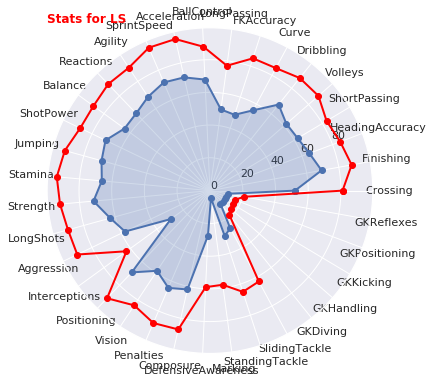

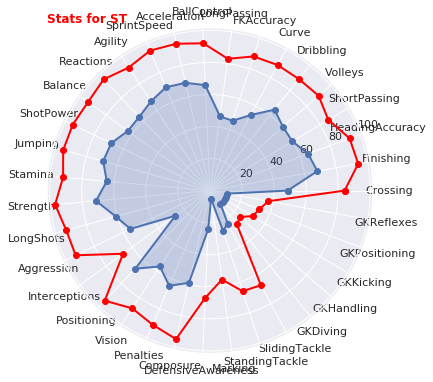

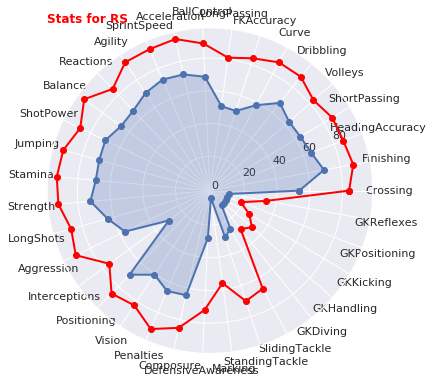

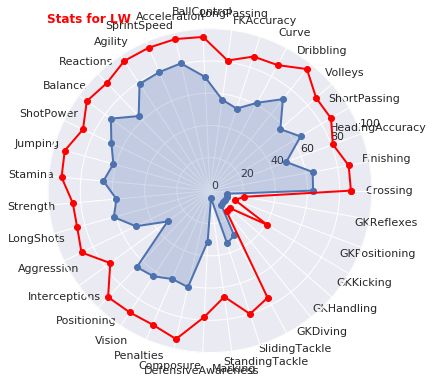

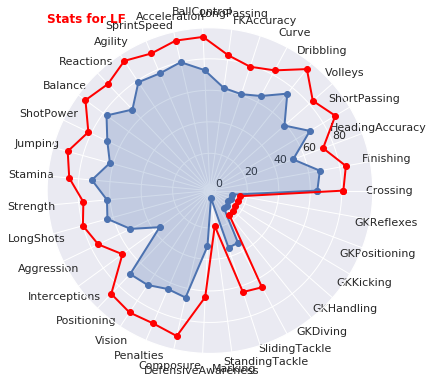

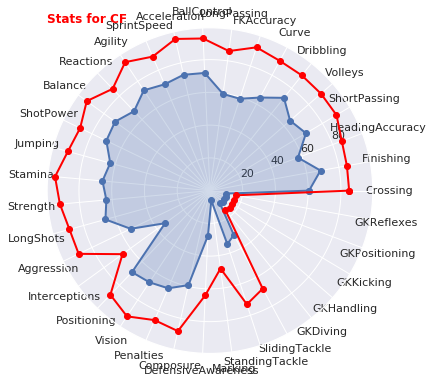

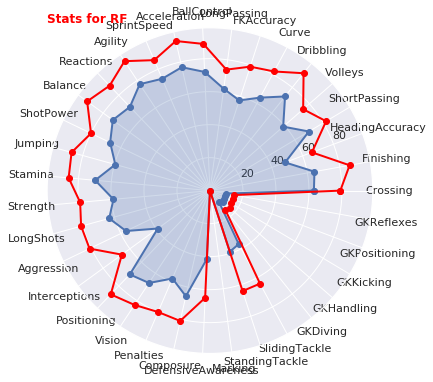

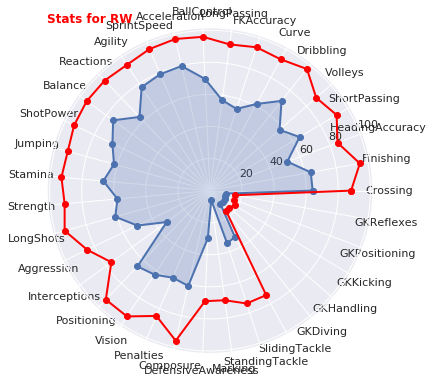

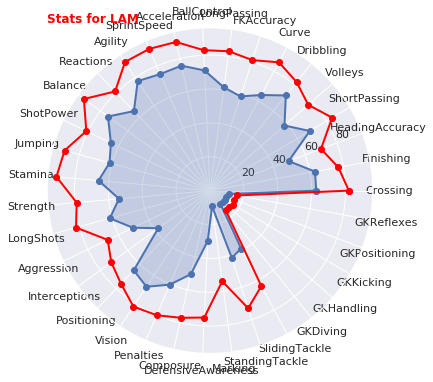

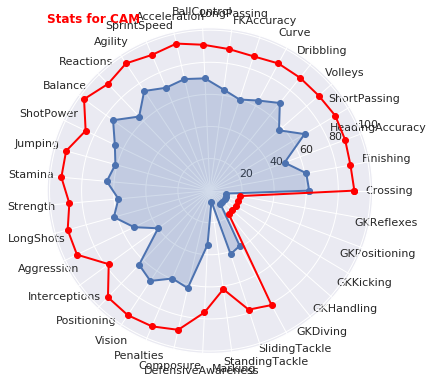

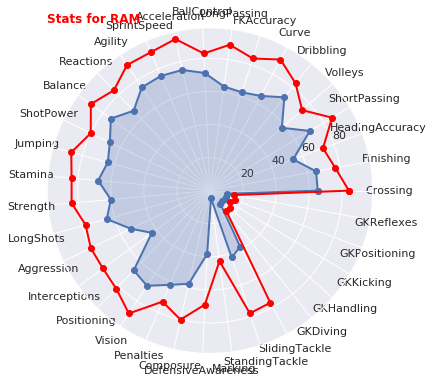

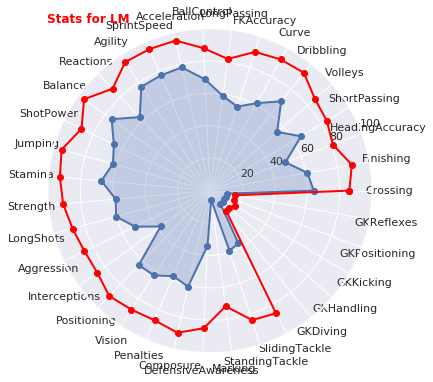

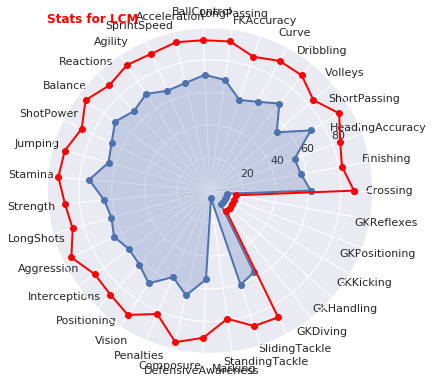

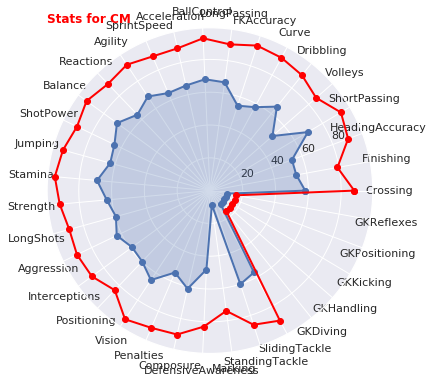

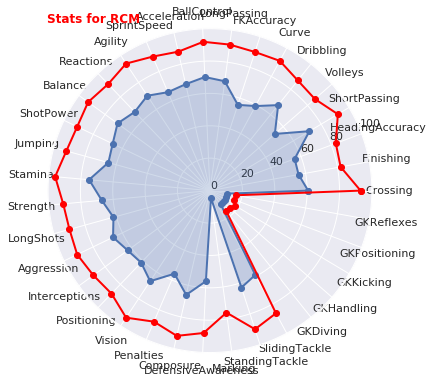

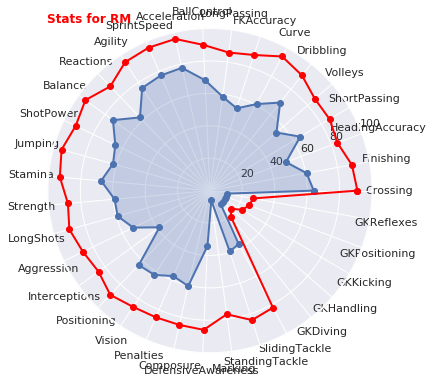

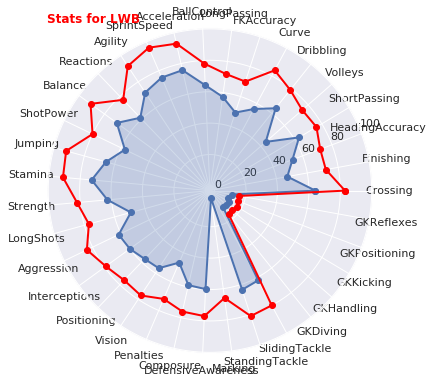

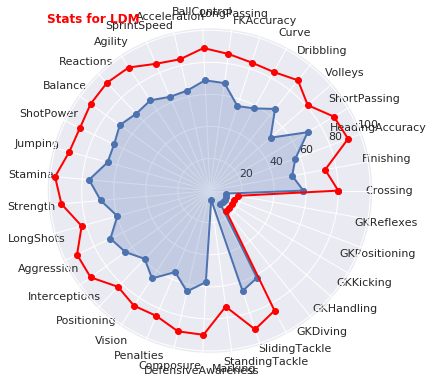

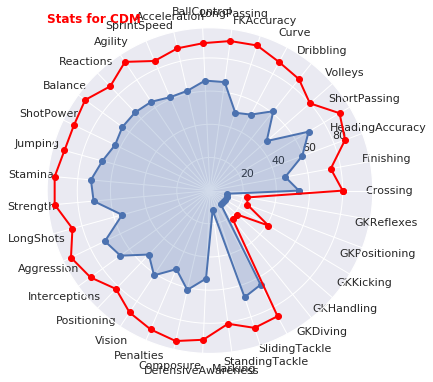

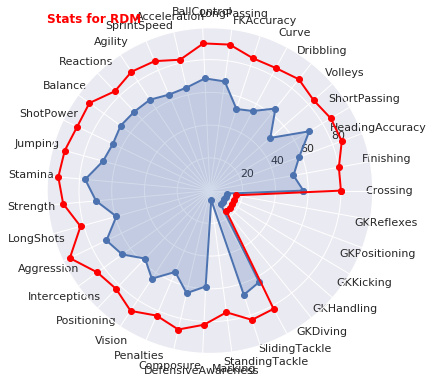

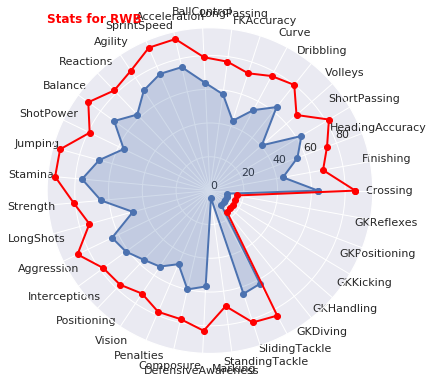

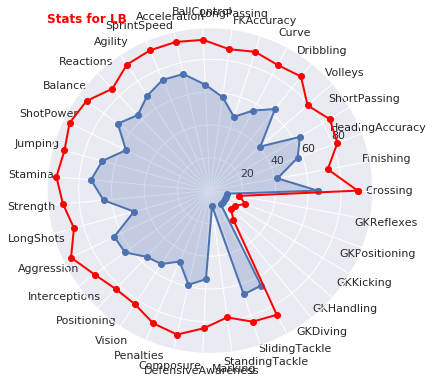

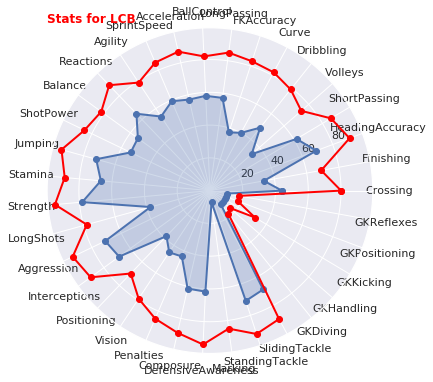

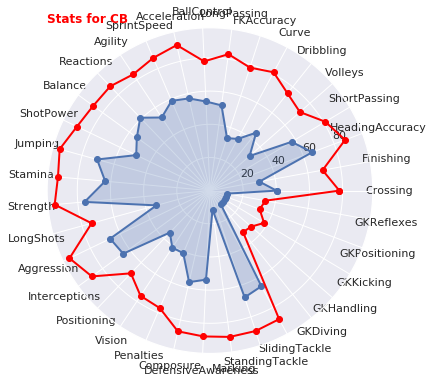

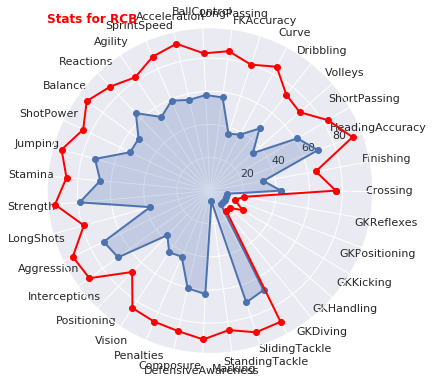

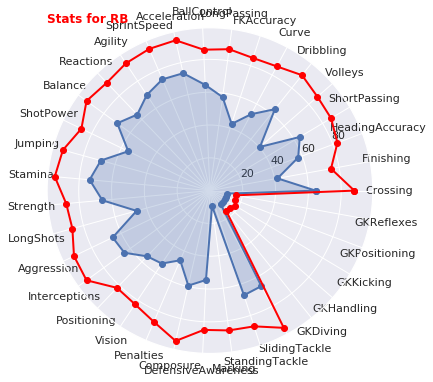

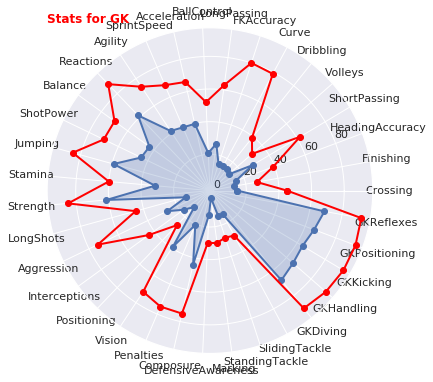

In [303]:
pos_radial_plot(position_attribute_mean_df,position_attribute_max_df)

In [304]:
df_for_clustering = df[all_attributes].copy(deep=True)

In [305]:
df_for_clustering.describe(include='all')

Body Type Preferred Foot  International Reputation     Weak Foot  \
count      14018          14018              14018.000000  14018.000000   
unique         3              2                       NaN           NaN   
top       Normal          Right                       NaN           NaN   
freq        8257          10680                       NaN           NaN   
mean         NaN            NaN                  1.159509      2.994222   
std          NaN            NaN                  0.466418      0.671186   
min          NaN            NaN                  1.000000      1.000000   
25%          NaN            NaN                  1.000000      3.000000   
50%          NaN            NaN                  1.000000      3.000000   
75%          NaN            NaN                  1.000000      3.000000   
max          NaN            NaN                  5.000000      5.000000   

         Skill Moves      Crossing     Finishing  HeadingAccuracy  \
count   14018.000000  14018.000000  14018.000000     14018.000000   
unique           NaN           NaN           NaN              NaN   
top              NaN           NaN           NaN              NaN   
freq             NaN           NaN           NaN              NaN   
mean        2.486232     52.276145     48.504423        54.454202   
std         0.779721     17.933521     19.301593        16.847547   
min         1.000000      6.000000      3.000000         4.000000   
25%         2.000000     42.000000     33.000000        47.000000   
50%         2.000000     57.000000     53.000000        58.000000   
75%         3.000000     65.000000     64.000000        66.000000   
max         5.000000     93.000000     95.000000        93.000000   

        ShortPassing       Volleys     Dribbling         Curve    FKAccuracy  \
count   14018.000000  14018.000000  14018.000000  14018.000000  14018.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean       61.192895     45.618062     58.473891     50.239121     45.114496   
std        13.826224     17.721863     18.047366     18.310666     17.673825   
min        11.000000      3.000000      4.000000      6.000000      4.000000   
25%        57.000000     33.000000     53.000000     38.000000     32.000000   
50%        64.000000     47.000000     63.000000     52.000000     44.000000   
75%        70.000000     59.000000     70.000000     64.000000     59.000000   
max        93.000000     90.000000     97.000000     94.000000     94.000000   

         LongPassing   BallControl  Acceleration   SprintSpeed       Agility  \
count   14018.000000  14018.000000  14018.000000  14018.000000  14018.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean       55.030960     61.334570     66.054359     66.260594     65.235911   
std        14.782108     15.724243     14.611495     14.364682     14.447517   
min         5.000000      5.000000     15.000000     11.000000     11.000000   
25%        47.000000     58.000000     59.000000     59.000000     58.000000   
50%        58.000000     65.000000     68.000000     69.000000     68.000000   
75%        66.000000     71.000000     76.000000     76.000000     75.000000   
max        92.000000     96.000000     97.000000     96.000000     96.000000   

           Reactions       Balance     ShotPower       Jumping       Stamina  \
count   14018.000000  14018.000000  14018.000000  14018.000000  14018.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN 

In [306]:
encode_these = ['Preferred Foot','Body Type']
df_for_clustering = pd.concat([df_for_clustering,
                               pd.get_dummies(df_for_clustering[encode_these],
                                              drop_first=True)],
                              axis=1)
df_for_clustering.drop(encode_these,axis='columns',inplace=True)

In [307]:
df_for_clustering.describe(include='all')

International Reputation     Weak Foot   Skill Moves      Crossing  \
count              14018.000000  14018.000000  14018.000000  14018.000000   
mean                   1.159509      2.994222      2.486232     52.276145   
std                    0.466418      0.671186      0.779721     17.933521   
min                    1.000000      1.000000      1.000000      6.000000   
25%                    1.000000      3.000000      2.000000     42.000000   
50%                    1.000000      3.000000      2.000000     57.000000   
75%                    1.000000      3.000000      3.000000     65.000000   
max                    5.000000      5.000000      5.000000     93.000000   

          Finishing  HeadingAccuracy  ShortPassing       Volleys  \
count  14018.000000     14018.000000  14018.000000  14018.000000   
mean      48.504423        54.454202     61.192895     45.618062   
std       19.301593        16.847547     13.826224     17.721863   
min        3.000000         4.000000     11.000000      3.000000   
25%       33.000000        47.000000     57.000000     33.000000   
50%       53.000000        58.000000     64.000000     47.000000   
75%       64.000000        66.000000     70.000000     59.000000   
max       95.000000        93.000000     93.000000     90.000000   

          Dribbling         Curve    FKAccuracy   LongPassing   BallControl  \
count  14018.000000  14018.000000  14018.000000  14018.000000  14018.000000   
mean      58.473891     50.239121     45.114496     55.030960     61.334570   
std       18.047366     18.310666     17.673825     14.782108     15.724243   
min        4.000000      6.000000      4.000000      5.000000      5.000000   
25%       53.000000     38.000000     32.000000     47.000000     58.000000   
50%       63.000000     52.000000     44.000000     58.000000     65.000000   
75%       70.000000     64.000000     59.000000     66.000000     71.000000   
max       97.000000     94.000000     94.000000     92.000000     96.000000   

       Acceleration   SprintSpeed       Agility     Reactions       Balance  \
count  14018.000000  14018.000000  14018.000000  14018.000000  14018.000000   
mean      66.054359     66.260594     65.235911     63.702311     64.848552   
std       14.611495     14.364682     14.447517      8.805731     13.986299   
min       15.000000     11.000000     11.000000     25.000000     12.000000   
25%       59.000000     59.000000     58.000000     58.000000     57.000000   
50%       68.000000     69.000000     68.000000     64.000000     67.000000   
75%       76.000000     76.000000     75.000000     70.000000     75.000000   
max       97.000000     96.000000     96.000000     96.000000     97.000000   

          ShotPower       Jumping       Stamina      Strength     LongShots  \
count  14018.000000  14018.000000  14018.000000  14018.000000  14018.000000   
mean      60.411899     65.928734     65.070623     66.499857     50.013768   
std       13.615805     11.846464     14.959511     12.273071     18.905589   
min        2.000000     19.000000     13.000000     20.000000      4.000000   
25%       51.000000     59.000000     59.000000     59.000000     37.000000   
50%       62.000000     67.000000     68.000000     68.000000     55.000000   
75%       70.000000     74.000000     75.000000     75.000000     64.000000   
max       95.000000     95.000000     97.000000     97.000000     94.000000   

         Aggression  Interceptions   Positioning        Vision     Penalties  \
count  14018.000000   14018.000000  14018.000000  14018.000000  14018.000000   
mean      57.899772      47.868169     52.999144     55.794122     50.750892   
std       16.955641      20.831342     19.048524     13.958396     15.576199   
min        9.000000       5.000000      2.000000      9.000000      7.000000   
25%       46.000000      27.000000     43.000000     47.000000     41.000000   
50%       61.000000      54.000000     58.000000     58.000000     52.000000   
75% 

This looks good--everything is numeric. We can scale these values and try feeding them to a model to see what it thinks.

In [308]:
df_for_clustering = pd.DataFrame(normalize(df_for_clustering))

Many models oblige us to choose the number of clusters. I tried using [the elbow method](https://bl.ocks.org/rpgove/0060ff3b656618e9136b) to find an optimal number of clusters for this data. Here's how that looks:

Text(0, 0.5, 'WCSS')

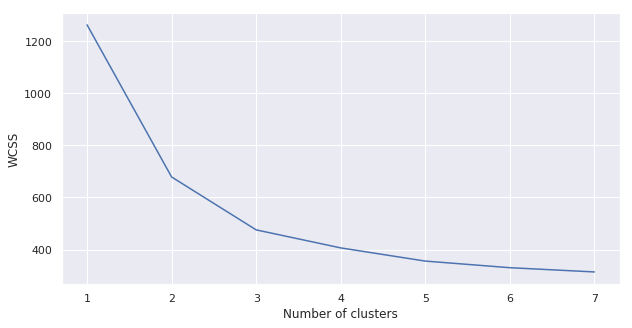

In [309]:
wcss = []
for i in range(1,8):
    kmeans = KMeans(i)
    kmeans.fit(df_for_clustering)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(10,5))
plt.plot(range(1,8),wcss)
plt.xticks(np.arange(1,8,step=1))
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

### Build a few models. What works?

Choosing a consistent number of clusters across models makes their output easier to compare. The elbow method suggests just two or three clusters.

Two clusters provides no insight--all of the models invariably choose goalkeepers vs. non-goalkeepers as the two clusters.

Three clusters are another possibility--a third cluster splits the non-goalkeeper positions into what is roughly the attacking positions and the defensive positions. (Midfielders are split between these two clusters.)

I also tried four clusters--a fourth cluster was not stable under either the K-Means or Gaussian Mixture models, but centered around the midfield positions.

In [310]:
N_CLUSTERS = 3

### K-Means was my first choice for a model, because of its speed and simplicity.

In [311]:
km = KMeans(N_CLUSTERS)
km.fit(df_for_clustering)
km_pred = km.predict(df_for_clustering)

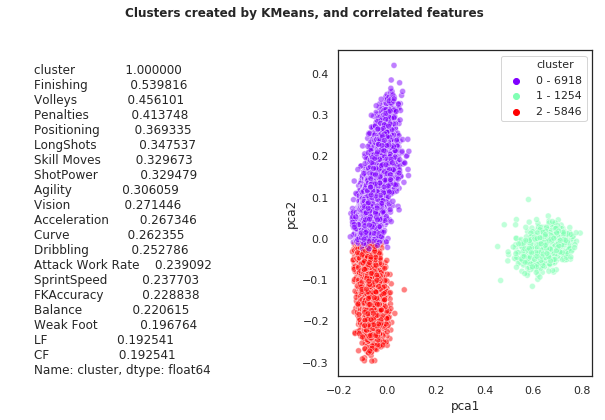

In [312]:
clust_pca = model_comparison(km,df,df_for_clustering,km_pred)

### I tried HDBSCAN after reading about [how it works](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html). 

Its method of calculating mutual reachability between data points instead of using centroids seemed like it might suit this data.

Unfortunately, the HDBSCAN model only wants to create two clusters: goalkeepers, and everyone else.

When I played with hyperparameters, I could coax it into creating a few more clusters, but ultimately this model didn't produce output that seemed at all insightful.

In [313]:
hdb = hdbscan.HDBSCAN(min_cluster_size=300, gen_min_span_tree=True)
hdb_pred = hdb.fit_predict(df_for_clustering)

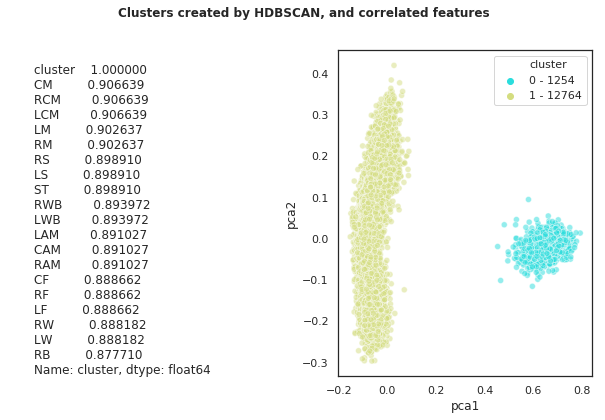

In [314]:
clust_pca = model_comparison(hdb,df,df_for_clustering,hdb_pred)

### Gaussian Mixture is a soft-clustering model.

Since the other two are hard-clustering models I thought I would give this a shot, and see how its output compares to the K-Means and HDBSCAN models.

The main difference here is in how the Gaussian Mixture model treats midfielders. It both gives results that differ slightly from K-Means, and gives results that are slightly more volatile between runs.

In [315]:
gm = GaussianMixture(n_components=N_CLUSTERS).fit(df_for_clustering)
gm_pred = gm.predict(df_for_clustering)

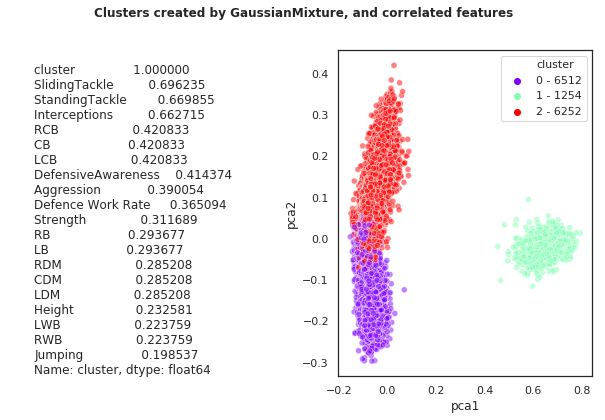

In [316]:
pca_df = model_comparison(gm,df,df_for_clustering,gm_pred)

We can use silhouette analysis to show that three clusters was the best choice. For this analysis, the closer the score is to 1, the more points are far away from points in a neighboring cluster.

With an average score of > .9, the three-cluster option is by far the best.

For n_clusters = 2 The average silhouette_score is : 0.8365055996294737
For n_clusters = 3 The average silhouette_score is : 0.9216960818926211
For n_clusters = 4 The average silhouette_score is : 0.7554436156933947
For n_clusters = 5 The average silhouette_score is : 0.5867819481261668
For n_clusters = 6 The average silhouette_score is : 0.5412660598512237


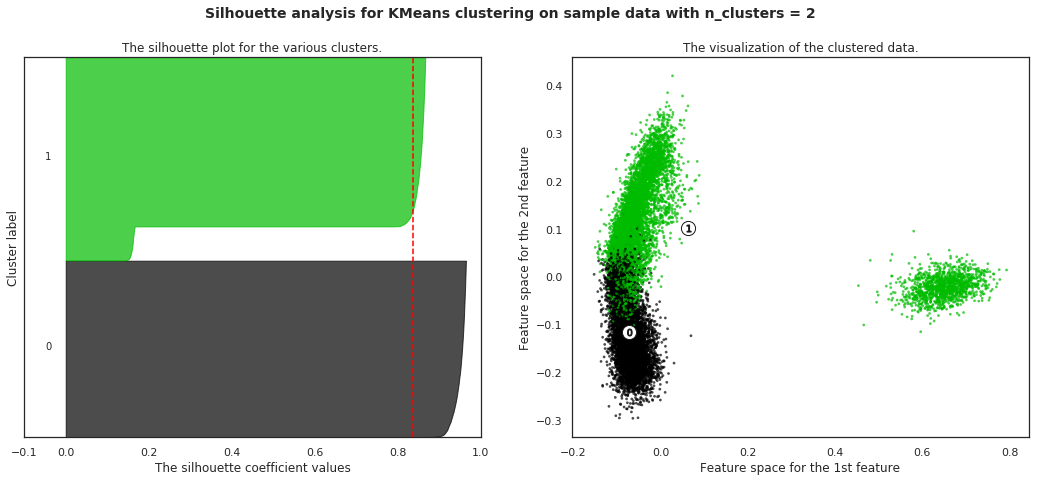

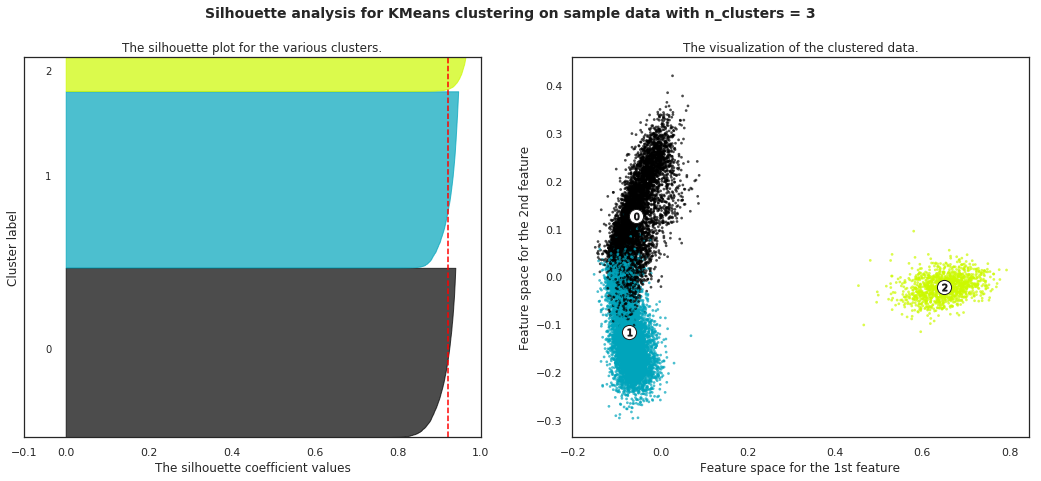

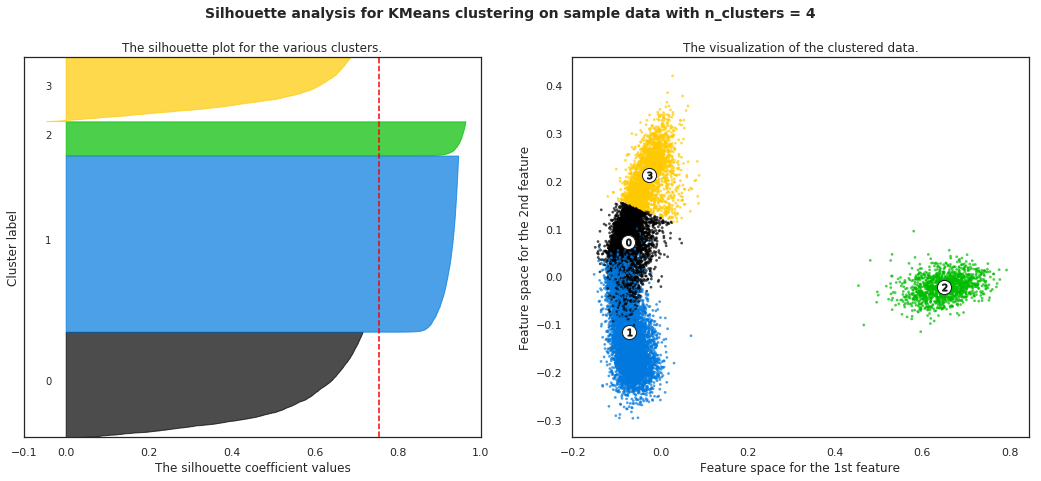

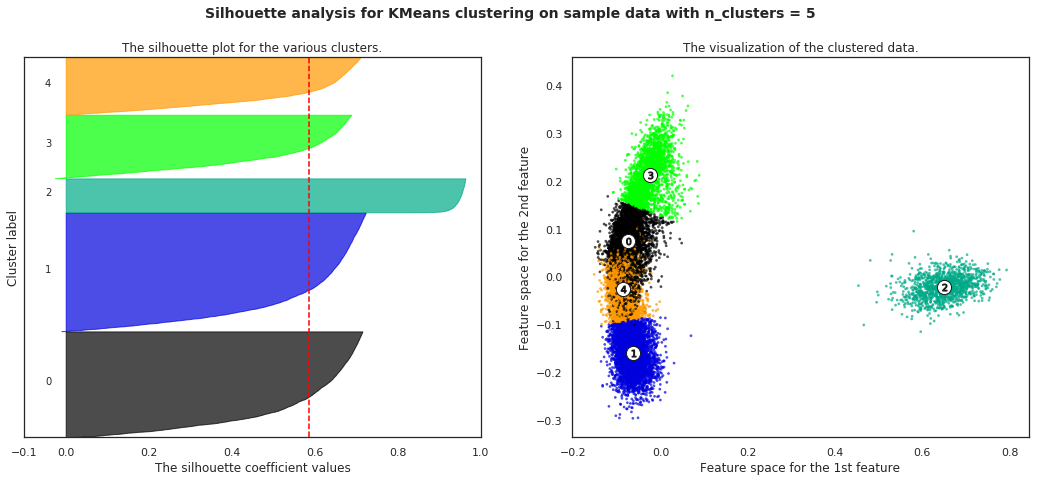

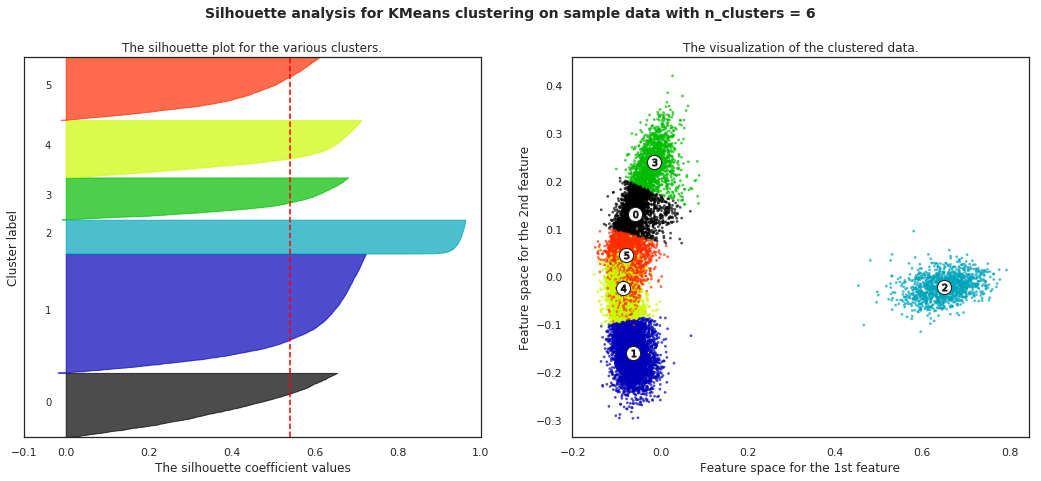

In [317]:
silhouette_plot(pca_df)

Here, we choose which model's output to use. km = K-Means; gm = Gaussian Mixture.

In [318]:
y_pred = gm_pred
if ('cluster' in df.columns):
    df.drop('cluster',axis='columns',inplace=True)
df = pd.concat([df.reset_index(drop=True),pd.Series(y_pred)],axis=1)
df.rename({0: 'cluster'},axis='columns',inplace=True)

## Understanding model behavior--what did it do?

Goalkeepers ended up in their own cluster. There are some very specific attributes for goalkeepers, which I suspect is why it was so easy for the models to separate them from the rest of the pack.

For non-goalkeepers, most attributes are shared across positions, though some do favor a particular position. Those shared characteristics mean that the boundaries between clusters are less obvious.

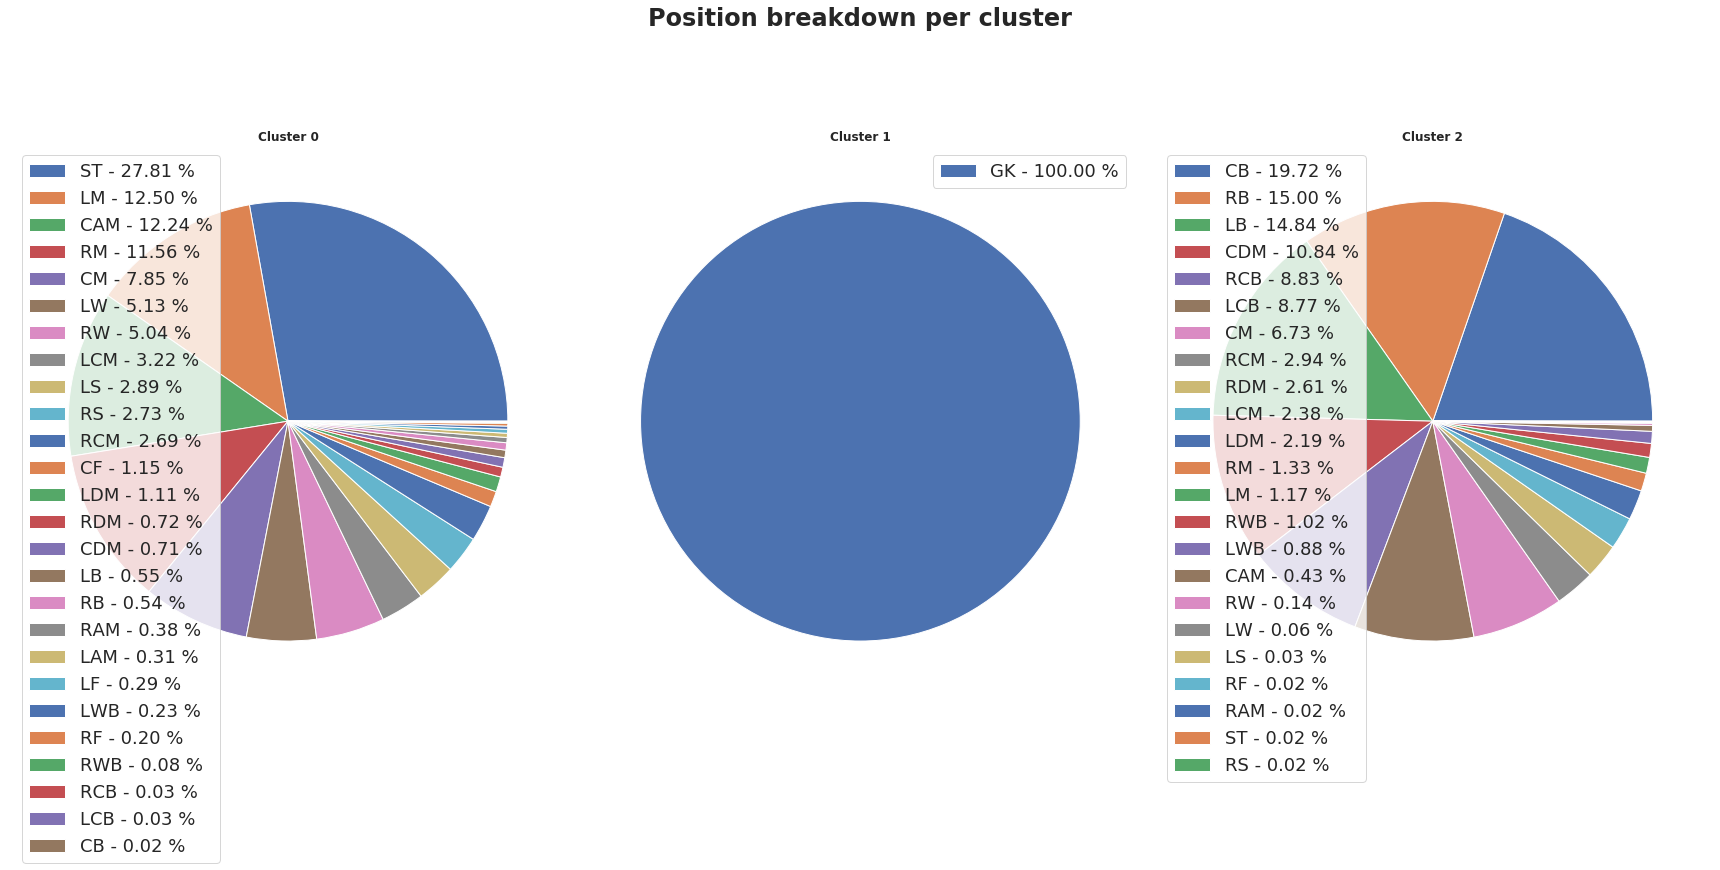

In [319]:
cluster_pie(df,'Position')

In [320]:
cluster_attribute_dict = {}
cluster_attribute_mean_df = pd.DataFrame(columns=continuous_attributes)
cluster_attribute_max_df = pd.DataFrame(columns=continuous_attributes)
for attribute in continuous_attributes:
    cluster_attribute_dict[attribute] = {}
    for cluster in sorted(set(df['cluster'])):
        cluster_attribute_dict[attribute][cluster] = {}
        cluster_mean = df.loc[df['cluster'] == cluster,attribute].mean()
        cluster_attribute_dict[attribute][cluster]['mean'] = cluster_mean
        cluster_attribute_mean_df.loc[cluster,attribute] = cluster_mean
        cluster_max = df.loc[df['cluster'] == cluster,attribute].max()
        cluster_attribute_dict[attribute][cluster]['max'] = cluster_max
        cluster_attribute_max_df.loc[cluster,attribute] = cluster_max

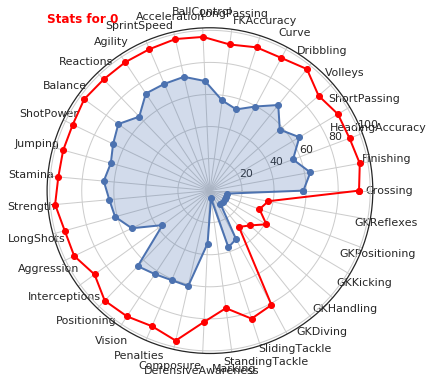

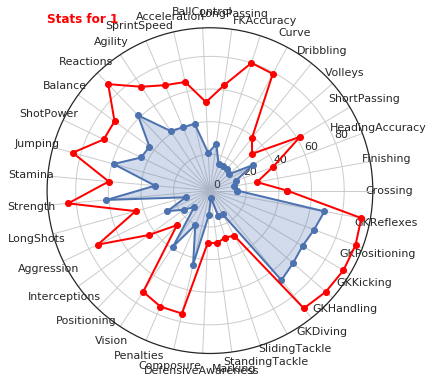

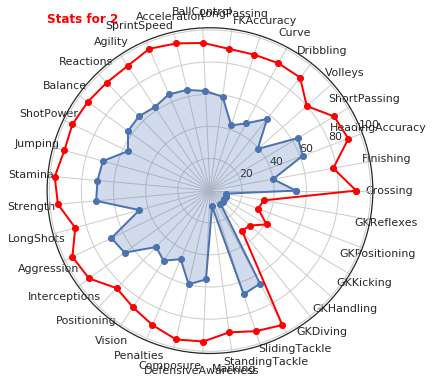

In [321]:
pos_radial_plot(cluster_attribute_mean_df,cluster_attribute_max_df)

__What the model _did_ is cluster players with similarly strong attributes.__ The desired attributes shift across positions on the pitch, meaning the cluster with the strongest forwards is not the same as the cluster with the strongest defensive players.

We can check the summary statistics for the ratings of players in each cluster, and whittle down our field by finding the cluster with the most highly-ranked players.

### Distribution of player position scores by cluster

__We need to identify the cluster containing the strongest players for each position.__
* Ideally: create a new measure of player strength based on attributes
    * This makes better use of the same data that the model saw

* Time constraints: lean on player rankings in the existing dataset
    * Good way to confirm the model's work; however...
    * Model's work counts for less

These plots provide some insight on which clusters hold the higher-ranked players for each of the positions. Given that the model I chose was only given player attributes, these plots using player rankings confirm that it did a decent job of separating higher-ranked players for each position into the same cluster.

All of the models fell short of consistently separating some midfielder and/or defensive back positions--in a few of those positions, the distributions of the clusters are nearly identical.

In an attempt to identify the best cluster for a given position, I performed some serious number crunching on various statistical measures of the attributes in each cluster, including:

* Finding the mean and max for each attribute of a position overall, and for each cluster, then comparing the differences
* Finding the number of attributes for which this difference was >= 0
* Finding the clusters with the highest sum and mean of the difference

And after doing that work, I realized that I just needed to look for the _largest_ cluster for a given position--it consistently holds the highest-ranked players.

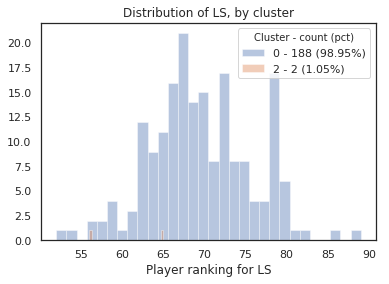

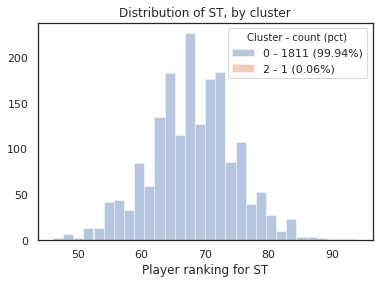

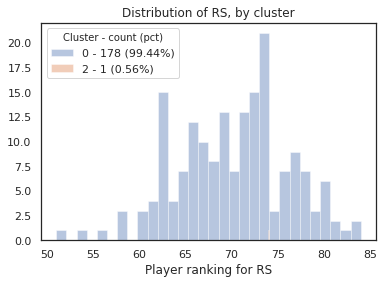

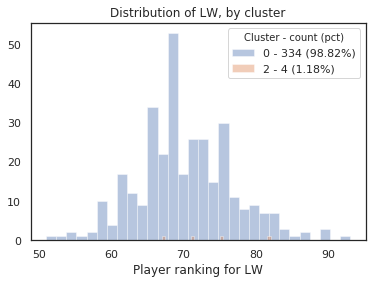

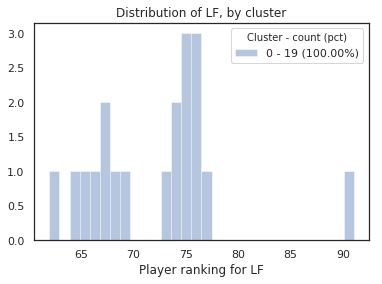

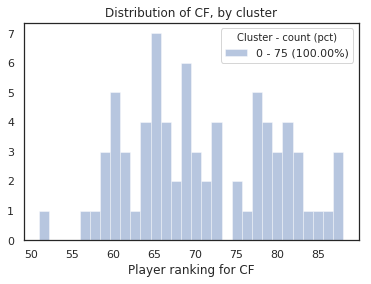

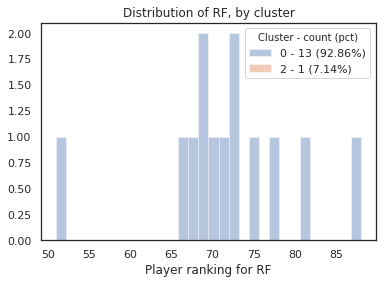

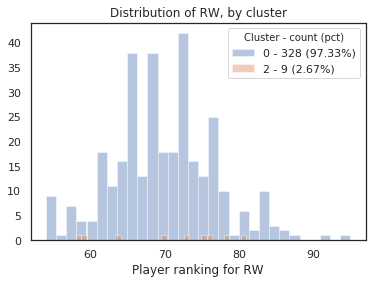

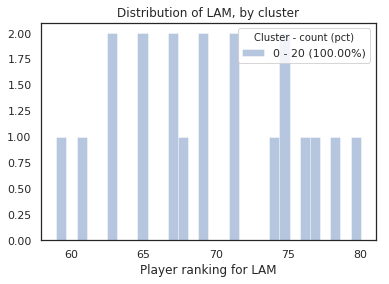

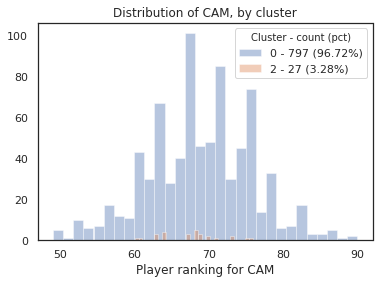

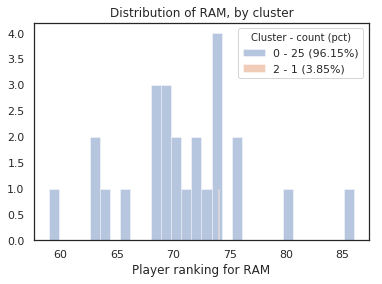

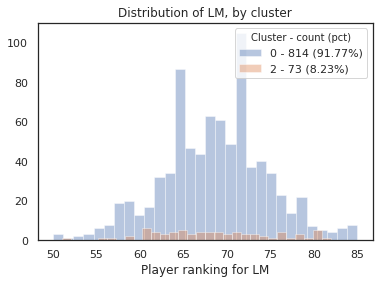

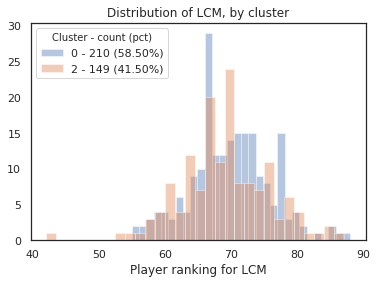

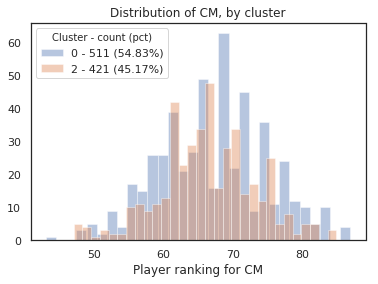

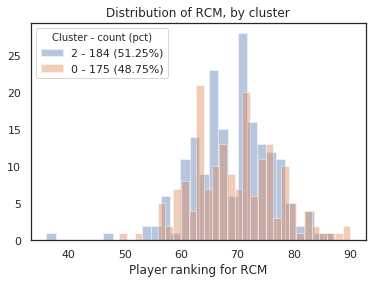

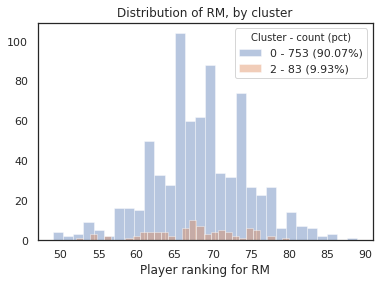

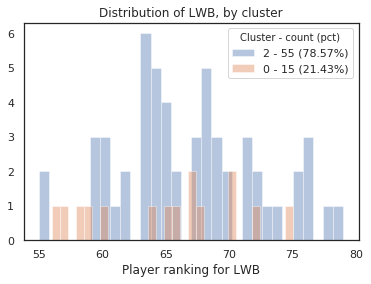

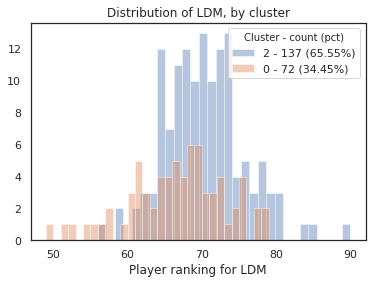

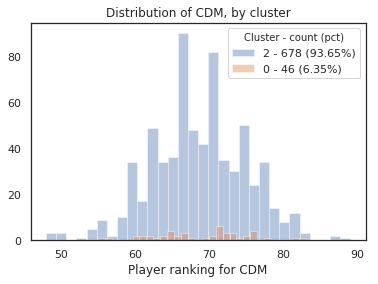

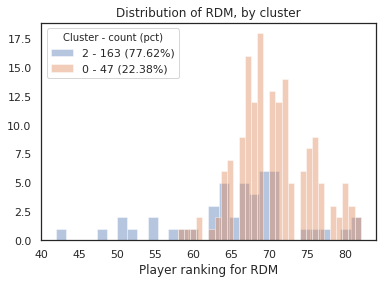

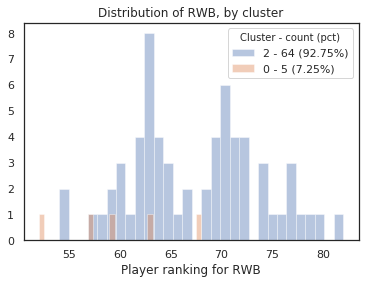

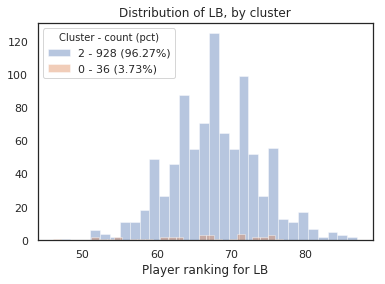

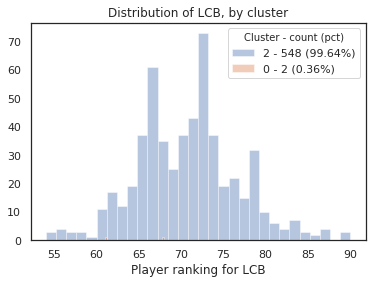

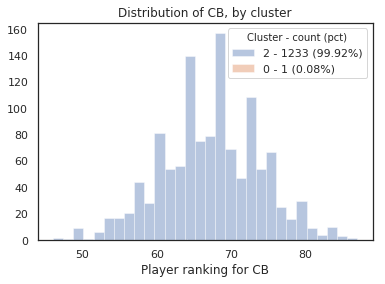

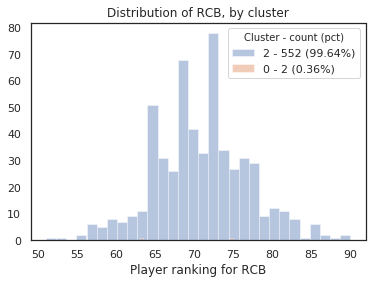

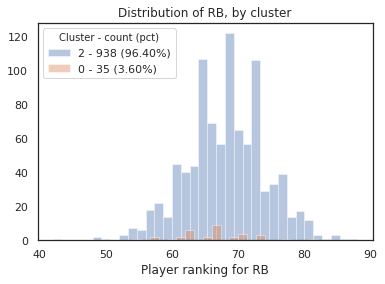

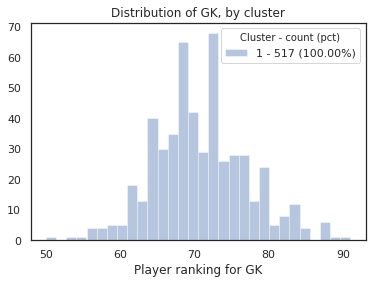

In [322]:
for position in all_positions:
    score_distribution(df.loc[(df['Position'] == position) & (df[position] > 0),[position,'cluster']],position)

In [323]:
best_cluster_per_position = {}
for position in all_positions:
    best_cluster_per_position[position] = df.loc[df['Position'] == position,['Position','cluster']]\
                                            .groupby('cluster').count().idxmax().values[0]

In [324]:
best_cluster_per_position

{'LS': 0,
 'ST': 0,
 'RS': 0,
 'LW': 0,
 'LF': 0,
 'CF': 0,
 'RF': 0,
 'RW': 0,
 'LAM': 0,
 'CAM': 0,
 'RAM': 0,
 'LM': 0,
 'LCM': 0,
 'CM': 0,
 'RCM': 2,
 'RM': 0,
 'LWB': 2,
 'LDM': 2,
 'CDM': 2,
 'RDM': 2,
 'RWB': 2,
 'LB': 2,
 'LCB': 2,
 'CB': 2,
 'RCB': 2,
 'RB': 2,
 'GK': 1}

## Satisfied with the models' clustering on attributes? Let's use it to help us choose the best players.

Once we've identified the cluster with the best players for a position, we can compare the players' strengths and salary ranges to determine where our money will be best spent. 

I read an article on The Athletic about [the current top-ranked manager of the Premier League fantasy football league](https://theathletic.com/1271013/2019/10/08/meet-the-former-liverpool-defender-who-is-currently-the-worlds-no-1-fantasy-football-manager/) (subscription required). Some of his best tips:

* "I think a lot of people fall into the trap of being too loyal to the club they support. You have to let your head rule your heart."
* "People go for [Liverpool defenders] Virgil Van Dijk, Andy Robertson and Trent Alexander-Arnold but they're expensive to buy. Conceding a goal affects their points and despite their great results, Liverpool haven't been keeping many clean sheets. You're better off having a sh\*t defence and spending the money on goalscoring midfielders instead. You can't put all your eggs in one basket."

In [325]:
# These Bokeh scatterplots don't display properly in the slideshow. :(
for position in all_positions:
    score_wage(df.loc[(df[position] > 85) & (df['Wage'] > 0)],position)

__I'm aiming for a 4-3-3 formation for my fantasy team__ (4 defenders, 3 midfielders, 3 forwards)--this is one of the most common formations.

We have data for a lot more than the ten positions this formation requires, so let's group the position rankings we have in ways that make sense.

Use this dictionary to hold all of the information we need to find the best starting 11.

'affinity' describes the general side of the pitch for this position. If position affinity matches a player's affinity during the calculations, that player will be given a slight bump in the rankings.

'wage%' is a way to raise the ceiling, in case we want to spend more for a position, or in case we can't find a player in the desired wage range who ranks highly enough to be considered.

In [326]:
starting_players = {'Left Forward': {'positions': ['LF','LS','LW'], 
                                     'affinity': 'L',},
                    'Center Forward': {'positions': ['CF','ST',], 
                                       'affinity': 'C',
                                       'wage%': 1.5,},
                    'Right Forward': {'positions': ['RF','RS','RW'], 
                                      'affinity': 'R',},
                    'Left Midfield': {'positions': ['LM','LAM','CAM','LCM',], 
                                      'affinity': 'L',},
                    'Center Midfield': {'positions': ['CM','CAM','LCM','RCM'], 
                                        'affinity': 'C',},
                    'Right Midfield': {'positions': ['RM','RAM','CAM','RCM',], 
                                       'affinity': 'R',},
                    'Left Back': {'positions': ['LB','LWB','LDM','CDM',], 
                                  'affinity': 'L',},
                    'Right Back': {'positions': ['RB','RWB','RDM','CDM',], 
                                   'affinity': 'R',},  
                    'Left-Center Back': {'positions': ['LCB','CB','LDM'], 
                                         'affinity': 'LC',},
                    'Right-Center Back': {'positions': ['RCB','CB','RDM'], 
                                          'affinity': 'RC',},
                    'Goalkeeper': {'positions': ['GK'], 
                                   'affinity': 'GK',
                                   'wage%': 1.5,},
                   }

__Sanity check:__ make sure the positions I'm combining are members of the same cluster! If not, there will be problems...

In [327]:
check_position(starting_players,best_cluster_per_position)

Left Forward position list: ['LF', 'LS', 'LW']
Center Forward position list: ['CF', 'ST']
Right Forward position list: ['RF', 'RS', 'RW']
Left Midfield position list: ['LM', 'LAM', 'CAM', 'LCM']
Center Midfield position list: ['CM', 'CAM', 'LCM', 'RCM']
	Modified positions for Center Midfield! Was: ['CM', 'CAM', 'LCM', 'RCM']; now: ['CM', 'CAM', 'LCM']
Right Midfield position list: ['RM', 'RAM', 'CAM', 'RCM']
	Modified positions for Right Midfield! Was: ['RM', 'RAM', 'CAM', 'RCM']; now: ['RM', 'RAM', 'CAM']
Left Back position list: ['LB', 'LWB', 'LDM', 'CDM']
Right Back position list: ['RB', 'RWB', 'RDM', 'CDM']
Left-Center Back position list: ['LCB', 'CB', 'LDM']
Right-Center Back position list: ['RCB', 'CB', 'RDM']
Goalkeeper position list: ['GK']
Positions are grouped correctly based on clusters


## Let's choose the best player for each position in our formation!

This function grew iteratively, with each major iteration looking something like:
1. Give me the best player for this position--money is no object.
2. Okay, trading champagne for soda: give me the best player for the mean salary (or less!) for a given position.
3. It would make a lot of sense for a player who typically plays left/center/right to be shown some kind of additional consideration for a position on that side of the pitch. I called this an "affinity", and award a small bonus in the calculations when the player's affinity matches the position.
    * __Example:__ Mo Salah typically plays Right Wing, but ranks highly in other forward positions. I don't want him to end up as a Left Forward or Center Forward just because those positions were calculated before Right Forward.)
4. Trading soda for...better soda? I want the players' ratings to count for more. If they're really good and not _too_ much more expensive, let's spend a little bit more, and hire the better player.
5. On that note, let's also institute a wage floor, so _really_ cheap players don't get the nod when higher-ranked players are both available, and still within our budget.

I also tried to anticipate a case where our combo of player ranking and wage range doesn't leave us with any players for a position, and built in a chance to raise the wage ceiling by multiplying the mean value by some decimal value. I use it for the Center Forward and Goalkeeper positions, but honestly I don't know whether it makes a difference there.

In an earlier version of the dataset, I was concerned about finding a good Left Back for my budget...it's slim pickins if you want a good one who is also relatively cheap.

In [328]:
df = best_for_position(df,starting_players,debug=True)

Starter: Left Forward
               Name    Wage Position  affinity_bonus  Left Forward  rankweight
0           L. Sané  195000       LW             1.5     85.333333    4.779834
118       P. Dybala  215000       CF             1.0     86.333333    2.992934
152     R. Sterling  255000       LW             1.5     86.333333    3.785181
155       Neymar Jr  290000       LW             1.5     90.666667    3.855105
203        M. Salah  240000       RW             1.0     89.666667    3.003875
206         H. Kane  220000       ST             1.0     87.000000    2.993195
244         S. Mané  220000       LW             1.5     89.000000    4.806607
245         G. Bale  250000       RM             1.0     87.000000    2.634012
249  R. Lewandowski  235000       LS             1.5     87.333333    4.251709
267   P. Aubameyang  205000       LM             1.5     86.333333    4.708395
472       E. Cavani  195000       ST             1.0     85.666667    3.224044
539      K. Benzema  285000   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

              Name    Wage Position  affinity_bonus  Right Midfield  \
39       K. Mbappé  155000       RM             1.5       89.000000   
100     O. Dembélé  195000       RW             1.5       85.333333   
118      P. Dybala  215000       CF             1.0       88.666667   
141   A. Griezmann  370000      CAM             1.0       89.666667   
152    R. Sterling  255000       LW             1.0       88.000000   
155      Neymar Jr  290000       LW             1.0       92.666667   
158       P. Pogba  250000      RDM             1.5       86.666667   
206        H. Kane  220000       ST             1.0       85.666667   
209   K. De Bruyne  370000      RCM             1.0       91.000000   
224     C. Eriksen  205000      CAM             1.0       88.666667   
245        G. Bale  250000       RM             1.5       85.333333   
250       Coutinho  175000      CAM             1.0       87.333333   
309           Isco  245000       LW             1.0       86.000000   
316   

In [329]:
html_file = open('starting_players.html',"w")
html_file.write(render_starters(df,starting_players))
html_file.close()

# And here are my starting 11!

In [330]:
# This renders poorly in the notebook...sorry.
from IPython.display import HTML
HTML(filename='starting_players.html')

### And let's see how much money we spent on the players we chose.

__NOTE:__ I didn't finish implementing a salary cap.
* The FIFA wage and salary data don't line up with the handful of players' salaries I spot-checked against [Spotrac](https://www.spotrac.com/epl/liverpool-f.c/payroll/), which tracks contracts and salaries for players across a number of professional sports.

__Example:__
Sadio Mané
* FIFA: Wage of €220,000 (not sure about the pay period). Value of €62,000,000.
* Spotrac: Weekly salary of £100,000. Annual salary £5.2 million.


* Fantasy Premier League sets a cap of £100 million, so I used that value as a starting point. I ended up dropping it to 10 million, and that still seems high for the provided wages.

In [331]:
budget = 10000000
spent = 0
for starter in starting_players:
    player_wage = df.loc[df['ID'] == starting_players[starter]['ID'],'Wage'].to_string(index=False)
    player_wage = int(player_wage)
    print("{}:\t{}, {}".format(starter,starting_players[starter]['Name'],player_wage))
    spent += player_wage
print('Spent: {}; Remaining budget: {}'.format(spent,budget-spent))

Left Forward:	S. Mané, 220000
Center Forward:	E. Cavani, 195000
Right Forward:	M. Salah, 240000
Left Midfield:	H. Son, 185000
Center Midfield:	Roberto Firmino, 170000
Right Midfield:	K. Mbappé, 155000
Left Back:	P. Lahm, 140000
Right Back:	Carvajal, 205000
Left-Center Back:	Thiago Silva, 135000
Right-Center Back:	D. Godín, 135000
Goalkeeper:	J. Oblak, 125000
Spent: 1905000; Remaining budget: 8095000


## Future work

* Find and implement a reasonable salary cap.
    * I already made some modifications to prevent the function from simply choosing the absolute highest-ranked players, or the absolute cheapest--the next step will be to have it decide whether it can afford a better player for a position, or whether it must settle for a player who may be marginally worse, but who fits the budget.
* Use a different site for salary/wage information, like Spotrac.
* Set the budget in dollars, euros, UK pound sterling, etc. The default on the website is euros, but if we only want to look at MLS players, for instance, US dollars would make more sense.
* FIFA 2020 data is updated every two weeks or so. Automated refresh of the dataset? Use an API instead of scraping?
* Build a dashboard that allows a person to select a desired salary range and min/max player ratings, using those criteria to select the best available player.
* Filters for league, which isn't in this dataset--focus on just MLS teams, or Premier League, Bundesliga, etc. Would have to pull in some league rosters or schedules to figure out which teams belong to which league(s).
* Factor in players' actual performance in recent matches (current season, maybe also recent past seasons).

# #YNWA